### nb to run tests on near-fiducual lhc (100)
    Omega            0.3133    
    OmegaLambda      0.6867    
    OmegaBaryon      0.0000    
    OmegaDM_2ndSpecies  0.0    
    HubbleParam      0.5619    
    Redshift         127       
    Sigma8           0.9093
    PrimordialIndex  1.0      

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from hodalpt.sims import alpt as CS
from hodalpt.sims import quijote as Q
from hodalpt import stats
rng = np.random.default_rng(42)

In [67]:
# draw samples from ALPT param priors and save to file

rng = np.random.default_rng(42)
import json

# Set up RNG
rng = np.random.default_rng(seed=42)  # Use your preferred seed

# Define prior ranges for each parameter
prior_ranges = {
    'theta_gal': {
        'alpha': (1.5, 2.5),
        'beta': (0, 5),
        'rhoeps': (10.0, 20.0),
        'eps': (0.3, 0.8),
        'dth': -0.7889,  # Fixed value
        'nmean': (1e-4, 5e-4)
    },
    'theta_rsd': {
        'bv': (0.5, 1.0),
        'bb': (0.8, 1.5),
        'betarsd': (1.0, 1.6),
        'gamma': (0.3, 0.7)
    }
}

# Generate 200 samples
n_samples = 200
samples = []

for i in range(n_samples):
    sample = {
        'theta_gal': {},
        'theta_rsd': {}
    }
    
    # Sample theta_gal parameters
    for param, value in prior_ranges['theta_gal'].items():
        if isinstance(value, tuple):  # Range to sample from
            sample['theta_gal'][param] = rng.uniform(value[0], value[1])
        else:  # Fixed value
            sample['theta_gal'][param] = value
    
    # Sample theta_rsd parameters
    for param, value in prior_ranges['theta_rsd'].items():
        sample['theta_rsd'][param] = rng.uniform(value[0], value[1])
    
    samples.append(sample)

# Write to JSON file
with open('/Users/mcc3842/CosmicSim2025/alpt_samples_rng42_beta.json', 'w') as f:
    json.dump(samples, f, indent=2)

print(f"Generated {n_samples} samples and saved to alpt_samples_rng42_beta.json")


Generated 200 samples and saved to alpt_samples_rng42_beta.json


In [ ]:
# ics = Q.IC('/Users/mcc3842/CosmicSim2025/data/quijote/latin_hypercube_HR/100')

In [2]:
fconfig = '/Users/mcc3842/CosmicSim2025/CosmicSignal4SimBIG/boxes/config_file.ini' # be sure config has correct quijote snap path
outdir = '/Users/mcc3842/CosmicSim2025/data/quijote/latin_hypercube_HR/100/alpt/'

xyz = CS.CSbox_alpt(fconfig, outdir, seed=0, make_ics=True, silent=True)

In [31]:

rng = np.random.default_rng(seed=42)  # Use your preferred seed

# Generate 10 samples
n_samples = 10
samples = []

for i in range(n_samples):
    theta_hod = {
        'logMmin': rng.normal(12.97, 0.11),
        'sigma_logM': rng.normal(0.40, 0.10),
        'logM0': rng.normal(13.67, 0.30),
        'logM1': rng.normal(13.68, 0.31),
        'alpha': rng.normal(0.79, 0.26),
        'Abias': rng.normal(0.01, 0.16),
        'eta_conc': rng.normal(1.11, 0.40),
        'eta_cen': rng.normal(0.31, 0.13),
        'eta_sat': rng.normal(0.85, 0.27)
    }
    samples.append({'theta_hod': theta_hod})

# Write to JSON file
with open('/Users/mcc3842/CosmicSim2025/hod_samples_rng42.json', 'w') as f:
    json.dump(samples, f, indent=2)

print(f"Generated {n_samples} HOD samples and saved to hod_samples_rng42.json")

Generated 10 HOD samples and saved to hod_samples_rng42.json


In [ ]:
import h5py
import json

# Load HOD parameters
with open('/Users/mcc3842/CosmicSim2025/hod_samples_rng42.json', 'r') as f:
    hod_samples = json.load(f)

# Process one at a time (can restart if interrupted)
for i in range(10):
    # Open in append mode
    with h5py.File('quijote_hod_results.h5', 'a') as f:
        
        # Skip if already computed
        if f'sample_{i}' in f:
            print(f"Sample {i} already exists, skipping...")
            continue
        
        print(f"Processing sample {i}/10...")
        
        theta_hod = hod_samples[i]['theta_hod']
        
        # Compute (this is where the heavy work happens)
        hod_quijote = Q.HODgalaxies(theta_hod,'/Users/mcc3842/CosmicSim2025/data/quijote/latin_hypercube_HR/100', z=0.5)
        xyz_q = Q.Box_RSD(hod_quijote, LOS=[0,0,1], Lbox=1000.) # in z-direction
        spec = stats.Pk_periodic(xyz_q.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=True,rsd=2)
        bispec = stats.B0_periodic(xyz_q.T, w=None, Lbox=1000., fft='pyfftw', silent=True)
        
        # Save to HDF5
        grp = f.create_group(f'sample_{i}')
        
        for key, val in theta_hod.items():
            grp.attrs[key] = val
        
        spec_grp = grp.create_group('spec')
        for key in ['k', 'p0k', 'p2k', 'p4k', 'counts', 
                    'k_kmu', 'mu_kmu', 'p_kmu', 'counts_kmu']:
            spec_grp.create_dataset(key, data=spec[key])
        
        bispec_grp = grp.create_group('bispec')
        for key in ['i_k1', 'i_k2', 'i_k3', 'p0k1', 'p0k2', 'p0k3', 
                    'b123', 'q123', 'counts']:
            bispec_grp.create_dataset(key, data=bispec[key])
        
        for key, val in bispec['meta'].items():
            bispec_grp.attrs[key] = val
        
        print(f"  Saved sample {i}")

print("Done!")

Processing sample 0/10...


/Users/mcc3842/CosmicSim2025/hodalpt/src/hodalpt/sims/quijote.py:132: RuntimeWarning: divide by zero encountered in divide
  conc = rstar[:,3] / rstar[:,4]
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received mu

------------------
392578 positions in 1000 box
nbar = 0.000393
392578 positions, Ntot=392578
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
  Saved sample 0
Processing sample 1/10...


/Users/mcc3842/CosmicSim2025/hodalpt/src/hodalpt/sims/quijote.py:132: RuntimeWarning: divide by zero encountered in divide
  conc = rstar[:,3] / rstar[:,4]
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received mu

------------------
491966 positions in 1000 box
nbar = 0.000492
491966 positions, Ntot=491966
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
  Saved sample 1
Processing sample 2/10...


/Users/mcc3842/CosmicSim2025/hodalpt/src/hodalpt/sims/quijote.py:132: RuntimeWarning: divide by zero encountered in divide
  conc = rstar[:,3] / rstar[:,4]
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received mu

------------------
470123 positions in 1000 box
nbar = 0.000470
470123 positions, Ntot=470123
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
  Saved sample 2
Processing sample 3/10...


/Users/mcc3842/CosmicSim2025/hodalpt/src/hodalpt/sims/quijote.py:132: RuntimeWarning: divide by zero encountered in divide
  conc = rstar[:,3] / rstar[:,4]
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received mu

------------------
385186 positions in 1000 box
nbar = 0.000385
385186 positions, Ntot=385186
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
  Saved sample 3
Processing sample 4/10...


/Users/mcc3842/CosmicSim2025/hodalpt/src/hodalpt/sims/quijote.py:132: RuntimeWarning: divide by zero encountered in divide
  conc = rstar[:,3] / rstar[:,4]
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received mu

------------------
467799 positions in 1000 box
nbar = 0.000468
467799 positions, Ntot=467799
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
  Saved sample 4
Processing sample 5/10...


/Users/mcc3842/CosmicSim2025/hodalpt/src/hodalpt/sims/quijote.py:132: RuntimeWarning: divide by zero encountered in divide
  conc = rstar[:,3] / rstar[:,4]
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received mu

------------------
414824 positions in 1000 box
nbar = 0.000415
414824 positions, Ntot=414824
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
  Saved sample 5
Processing sample 6/10...


/Users/mcc3842/CosmicSim2025/hodalpt/src/hodalpt/sims/quijote.py:132: RuntimeWarning: divide by zero encountered in divide
  conc = rstar[:,3] / rstar[:,4]
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received mu

------------------
468511 positions in 1000 box
nbar = 0.000469
468511 positions, Ntot=468511
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
  Saved sample 6
Processing sample 7/10...


/Users/mcc3842/CosmicSim2025/hodalpt/src/hodalpt/sims/quijote.py:132: RuntimeWarning: divide by zero encountered in divide
  conc = rstar[:,3] / rstar[:,4]
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received mu

------------------
391668 positions in 1000 box
nbar = 0.000392
391668 positions, Ntot=391668
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
  Saved sample 7
Processing sample 8/10...


/Users/mcc3842/CosmicSim2025/hodalpt/src/hodalpt/sims/quijote.py:132: RuntimeWarning: divide by zero encountered in divide
  conc = rstar[:,3] / rstar[:,4]
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received mu

------------------
491799 positions in 1000 box
nbar = 0.000492
491799 positions, Ntot=491799
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
  Saved sample 8
Processing sample 9/10...


/Users/mcc3842/CosmicSim2025/hodalpt/src/hodalpt/sims/quijote.py:132: RuntimeWarning: divide by zero encountered in divide
  conc = rstar[:,3] / rstar[:,4]
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received mu

------------------
609799 positions in 1000 box
nbar = 0.000610
609799 positions, Ntot=609799
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
  Saved sample 9
Done!


In [8]:
import h5py
import json

# Load HOD parameters
with open('/Users/mcc3842/CosmicSim2025/alpt_samples_rng42_beta.json', 'r') as f:
    alpt_samples = json.load(f)

# Process one at a time (can restart if interrupted)
for i in range(200):
    # Open in append mode
    with h5py.File('/Users/mcc3842/CosmicSim2025/alpt_hod_results_beta05.h5', 'a') as f:
        
        # Skip if already computed
        if f'sample_{i}' in f:
            print(f"Sample {i} already exists, skipping...")
            continue
        
        print(f"Processing sample {i}/100...")
        
        theta_gal = alpt_samples[i]['theta_gal']
        theta_rsd = alpt_samples[i]['theta_rsd']
        
        # Compute (this is where the heavy work happens)
        xyz_g = CS.CSbox_galaxy(theta_gal, theta_rsd, outdir, silent=True)
        spec = stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=True,rsd=2)
        bispec = stats.B0_periodic(xyz_g.T, w=None, Lbox=1000., fft='pyfftw', silent=True)
        
        # Save to HDF5
        grp = f.create_group(f'sample_{i}')
        
        for key, val in theta_gal.items():
            grp.attrs[key] = val
        for key, val in theta_rsd.items():
            grp.attrs[key] = val
            
        spec_grp = grp.create_group('spec')
        for key in ['k', 'p0k', 'p2k', 'p4k', 'counts', 
                    'k_kmu', 'mu_kmu', 'p_kmu', 'counts_kmu']:
            spec_grp.create_dataset(key, data=spec[key])
        
        bispec_grp = grp.create_group('bispec')
        for key in ['i_k1', 'i_k2', 'i_k3', 'p0k1', 'p0k2', 'p0k3', 
                    'b123', 'q123', 'counts']:
            bispec_grp.create_dataset(key, data=bispec[key])
        
        for key, val in bispec['meta'].items():
            bispec_grp.attrs[key] = val
        
        print(f"  Saved sample {i}")

print("Done!")

Sample 0 already exists, skipping...
Sample 1 already exists, skipping...
Sample 2 already exists, skipping...
Sample 3 already exists, skipping...
Sample 4 already exists, skipping...
Sample 5 already exists, skipping...
Sample 6 already exists, skipping...
Sample 7 already exists, skipping...
Sample 8 already exists, skipping...
Sample 9 already exists, skipping...
Sample 10 already exists, skipping...
Sample 11 already exists, skipping...
Sample 12 already exists, skipping...
Sample 13 already exists, skipping...
Sample 14 already exists, skipping...
Sample 15 already exists, skipping...
Sample 16 already exists, skipping...
Sample 17 already exists, skipping...
Sample 18 already exists, skipping...
Sample 19 already exists, skipping...
Sample 20 already exists, skipping...
Sample 21 already exists, skipping...
Sample 22 already exists, skipping...
Sample 23 already exists, skipping...
Sample 24 already exists, skipping...
Sample 25 already exists, skipping...
Sample 26 already exis

In [9]:
def load_sample(filename, sample_idx):

    with h5py.File(filename, 'r') as f:
        grp = f[f'sample_{sample_idx}']
        
        result = {
            'params': dict(grp.attrs),
            'spec': {},
            'bispec': {}
        }
        
        # Load power spectrum
        spec_grp = grp['spec']
        for key in ['k', 'p0k', 'p2k', 'p4k', 'counts', 
                    'k_kmu', 'mu_kmu', 'p_kmu', 'counts_kmu']:
            result['spec'][key] = spec_grp[key][:]
        
        # Load bispectrum
        bispec_grp = grp['bispec']
        for key in ['i_k1', 'i_k2', 'i_k3', 'p0k1', 'p0k2', 'p0k3', 
                    'b123', 'q123', 'counts']:
            result['bispec'][key] = bispec_grp[key][:]
        
        result['bispec']['meta'] = dict(bispec_grp.attrs)
        
    return result


In [10]:
def load_powspec(filename, n_samples, k_min, k_max):
    with h5py.File(filename, 'r') as f:
        # sample_0 = f['sample_0']
        # n_k = len(sample_0['spec']['p0k'][:78]) # limit to k<0.5
         # Get k bins and find valid range
        k = f['sample_0/spec/k'][:]
        k_mask = (k >= k_min) & (k <= k_max)
        n_k = np.sum(k_mask)

        data = np.zeros((n_samples, n_k))
    
        for i in range(n_samples):
            # data[i, :] = f[f'sample_{i}/spec/p0k'][:78]
            p0k = f[f'sample_{i}/spec/p0k'][:]
            data[i, :] = p0k[k_mask]

    return data,  k[k_mask]
def load_p2k(filename, n_samples, k_min, k_max):
    with h5py.File(filename, 'r') as f:
        # sample_0 = f['sample_0']
        # n_k = len(sample_0['spec']['p0k'][:78]) # limit to k<0.5
         # Get k bins and find valid range
        k = f['sample_0/spec/k'][:]
        k_mask = (k >= k_min) & (k <= k_max)
        n_k = np.sum(k_mask)

        data = np.zeros((n_samples, n_k))
    
        for i in range(n_samples):
            # data[i, :] = f[f'sample_{i}/spec/p0k'][:78]
            p2k = f[f'sample_{i}/spec/p2k'][:]
            data[i, :] = p2k[k_mask]

    return data,  k[k_mask]
def load_bispec(filename, n_samples, kmin, kmax):
    with h5py.File(filename, 'r') as f:
        sample_0 = f['sample_0']
        bispec_grp = sample_0['bispec']
        
        # Calculate klim
        i_k1 = bispec_grp['i_k1'][:]
        i_k2 = bispec_grp['i_k2'][:]
        i_k3 = bispec_grp['i_k3'][:]
        k_fund = 2 * np.pi / 1000.
        k1, k2, k3 = i_k1 * k_fund, i_k2 * k_fund, i_k3 * k_fund

        klim = (k1 > kmin) & (k2 > kmin) & (k3 > kmin) & (k1 < kmax) & (k2 < kmax) & (k3 < kmax)
        n_triangles = np.sum(klim)
        
        data = np.zeros((n_samples, n_triangles))
        
        for i in range(n_samples):
            b123 = f[f'sample_{i}/bispec/b123'][:][klim]
            data[i, :] = b123

    return data

def load_q0(filename, n_samples, kmin, kmax):
    with h5py.File(filename, 'r') as f:
        sample_0 = f['sample_0']
        bispec_grp = sample_0['bispec']
        
        # Calculate klim
        i_k1 = bispec_grp['i_k1'][:]
        i_k2 = bispec_grp['i_k2'][:]
        i_k3 = bispec_grp['i_k3'][:]
        k_fund = 2 * np.pi / 1000.
        k1, k2, k3 = i_k1 * k_fund, i_k2 * k_fund, i_k3 * k_fund

        klim = (k1 > kmin) & (k2 > kmin) & (k3 > kmin) & (k1 < kmax) & (k2 < kmax) & (k3 < kmax)
        n_triangles = np.sum(klim)
        
        data = np.zeros((n_samples, n_triangles))
        
        for i in range(n_samples):
            q123 = f[f'sample_{i}/bispec/q123'][:][klim]
            data[i, :] = q123

    return data



In [11]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

kmin = 0.008
kmax = 0.8

# monopole 
alpt_pk, k_bins = load_powspec('/Users/mcc3842/CosmicSim2025/alpt_hod_results_beta05.h5', 200, k_min=kmin, k_max=kmax)
quijote_pk, _ = load_powspec('/Users/mcc3842/CosmicSim2025/quijote_hod_results.h5', 10, k_min=kmin, k_max=kmax)
X_pk = np.vstack([alpt_pk, quijote_pk])

pca_pk = PCA(n_components=3)
X_pk_pca = pca_pk.fit_transform(X_pk)

# quadrupole
alpt_p2k, k_bins = load_p2k('/Users/mcc3842/CosmicSim2025/alpt_hod_results_beta05.h5', 200, k_min=kmin, k_max=kmax)
quijote_p2k, _ = load_p2k('/Users/mcc3842/CosmicSim2025/quijote_hod_results.h5', 10, k_min=kmin, k_max=kmax)
X_p2k = np.vstack([alpt_p2k, quijote_p2k])

pca_p2k = PCA(n_components=3)
X_p2k_pca = pca_p2k.fit_transform(X_p2k)

# bispec
alpt_b0 = load_bispec('/Users/mcc3842/CosmicSim2025/alpt_hod_results_beta05.h5', 200, kmin=kmin, kmax=kmax)
quijote_b0 = load_bispec('/Users/mcc3842/CosmicSim2025/quijote_hod_results.h5', 10, kmin=kmin, kmax=kmax)
X_b0 = np.vstack([alpt_b0, quijote_b0])

pca_b0 = PCA(n_components=3)
X_b0_pca = pca_b0.fit_transform(X_b0)

# reduced bispec
alpt_q0 = load_q0('/Users/mcc3842/CosmicSim2025/alpt_hod_results_beta05.h5', 200, kmin=kmin, kmax=kmax)
quijote_q0 = load_q0('/Users/mcc3842/CosmicSim2025/quijote_hod_results.h5', 10, kmin=kmin, kmax=kmax)
X_q0 = np.vstack([alpt_q0, quijote_q0])

pca_q0 = PCA(n_components=3)
X_q0_pca = pca_q0.fit_transform(X_q0)

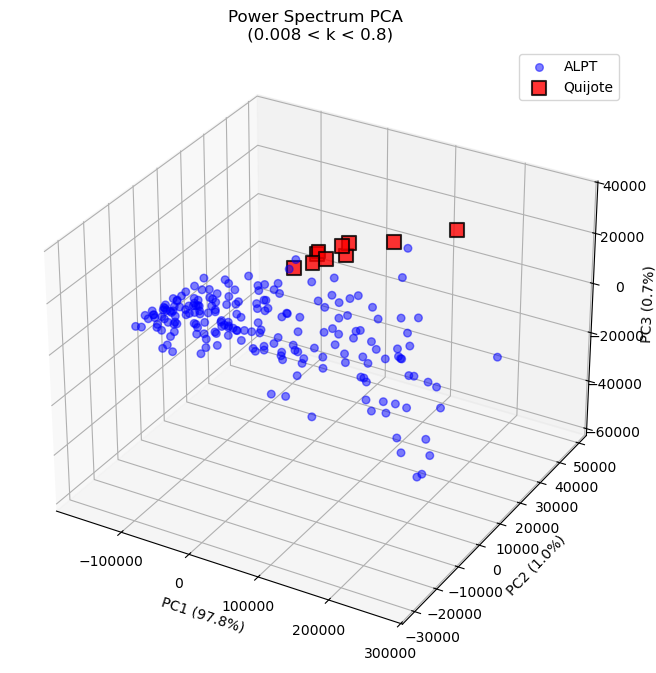

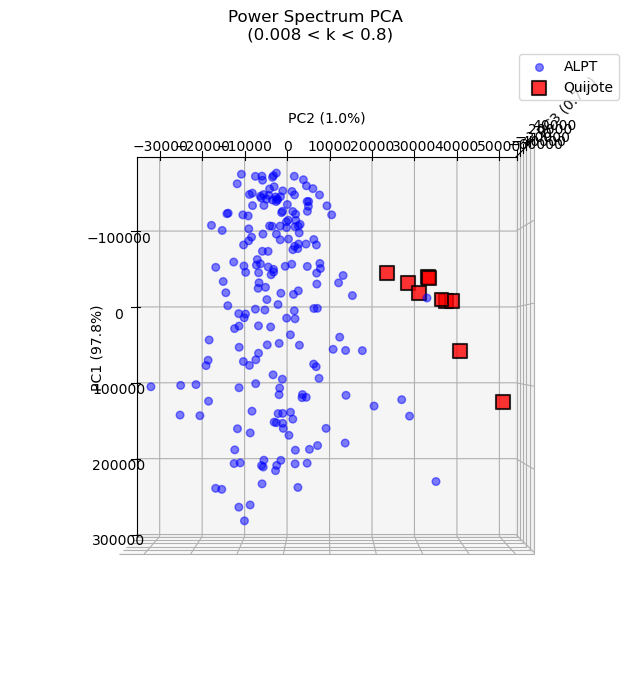

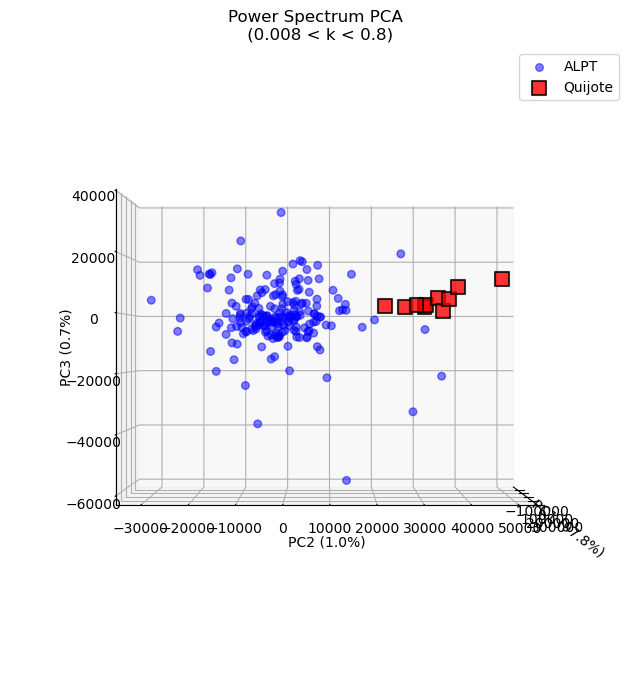

In [83]:
# Plot PCA for Powspec

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot ALPT samples
ax.scatter(X_pk_pca[:200, 0], X_pk_pca[:200, 1], X_pk_pca[:200, 2],
           c='blue', alpha=0.5, s=30, label='ALPT')

# Plot Quijote samples
ax.scatter(X_pk_pca[200:, 0], X_pk_pca[200:, 1], X_pk_pca[200:, 2],
           c='red', alpha=0.8, s=100, marker='s', 
           edgecolors='black', linewidths=1.5, label='Quijote')

ax.set_xlabel(f'PC1 ({pca_pk.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_pk.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_pk.explained_variance_ratio_[2]:.1%})')
ax.set_title('Power Spectrum: 3D PCA')
ax.legend()
ax.set_title(f'Power Spectrum PCA \n ({kmin} < k < {kmax})')
# # Looking down from above
# ax.view_init(elev=90, azim=0)

# # # Side view
# ax.view_init(elev=0, azim=0)
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pk_pca[:200, 0], X_pk_pca[:200, 1], X_pk_pca[:200, 2],
           c='blue', alpha=0.5, s=30, label='ALPT')

# Plot Quijote samples
ax.scatter(X_pk_pca[200:, 0], X_pk_pca[200:, 1], X_pk_pca[200:, 2],
           c='red', alpha=0.8, s=100, marker='s', 
           edgecolors='black', linewidths=1.5, label='Quijote')

ax.set_xlabel(f'PC1 ({pca_pk.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_pk.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_pk.explained_variance_ratio_[2]:.1%})')
ax.set_title('Power Spectrum: 3D PCA')
ax.legend()
ax.set_title(f'Power Spectrum PCA \n ({kmin} < k < {kmax})')
# # Looking down from above 
ax.view_init(elev=90, azim=0)
plt.show()
# # # Side view
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pk_pca[:200, 0], X_pk_pca[:200, 1], X_pk_pca[:200, 2],
           c='blue', alpha=0.5, s=30, label='ALPT')

# Plot Quijote samples
ax.scatter(X_pk_pca[200:, 0], X_pk_pca[200:, 1], X_pk_pca[200:, 2],
           c='red', alpha=0.8, s=100, marker='s', 
           edgecolors='black', linewidths=1.5, label='Quijote')

ax.set_xlabel(f'PC1 ({pca_pk.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_pk.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_pk.explained_variance_ratio_[2]:.1%})')
ax.set_title('Power Spectrum: 3D PCA')
ax.legend()
ax.set_title(f'Power Spectrum PCA \n ({kmin} < k < {kmax})')
# # Looking down from above 

ax.view_init(elev=0, azim=0)

plt.show()

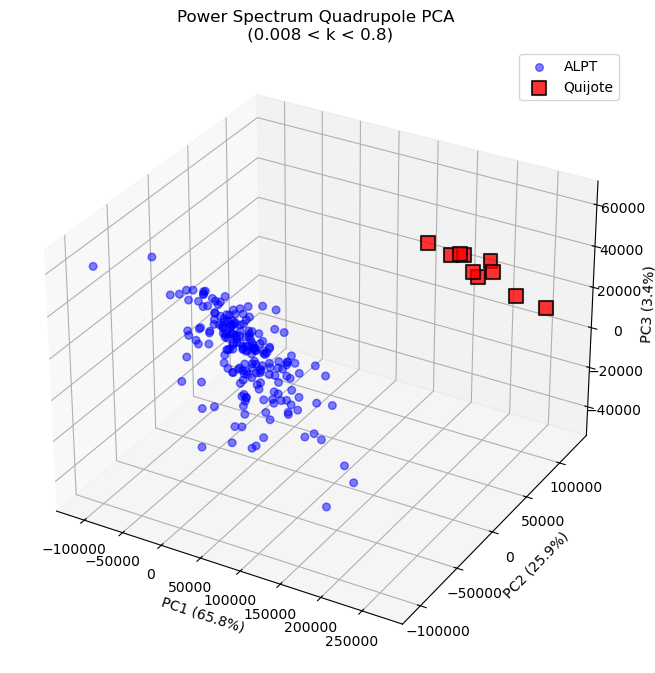

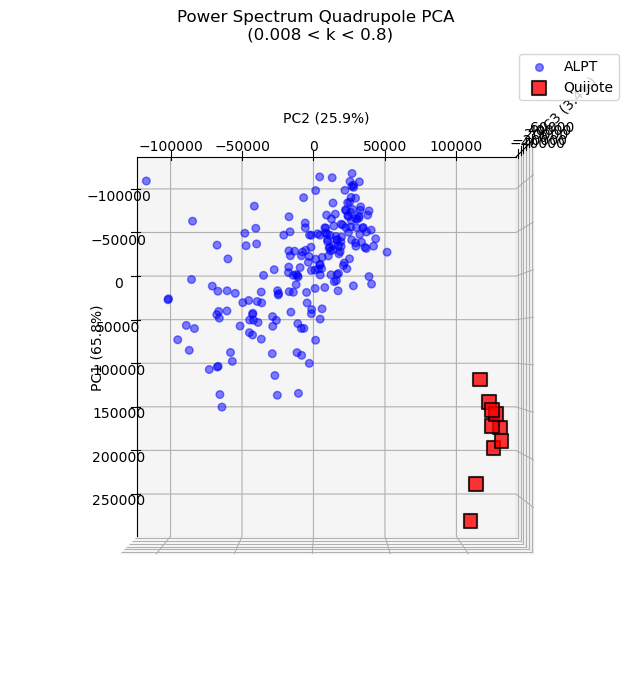

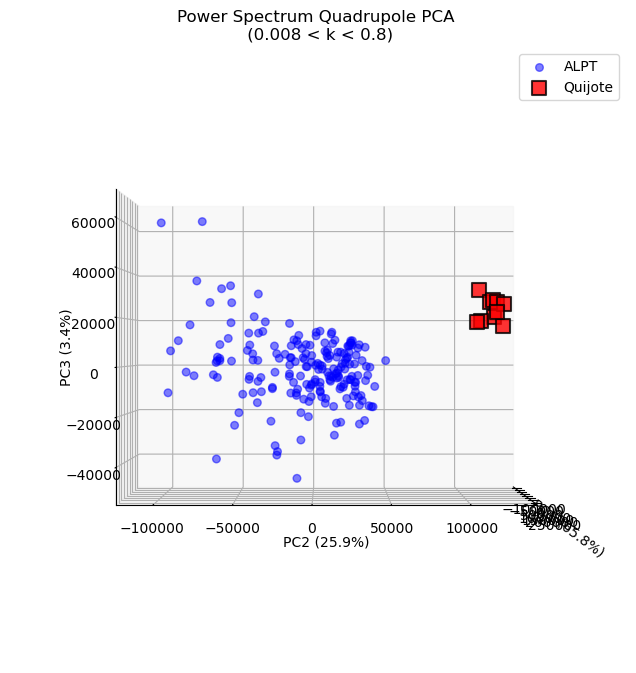

In [84]:
# Plot PCA for Powspec quadrupole 

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot ALPT samples
ax.scatter(X_p2k_pca[:200, 0], X_p2k_pca[:200, 1], X_p2k_pca[:200, 2],
           c='blue', alpha=0.5, s=30, label='ALPT')

# Plot Quijote samples
ax.scatter(X_p2k_pca[200:, 0], X_p2k_pca[200:, 1], X_p2k_pca[200:, 2],
           c='red', alpha=0.8, s=100, marker='s', 
           edgecolors='black', linewidths=1.5, label='Quijote')

ax.set_xlabel(f'PC1 ({pca_p2k.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_p2k.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_p2k.explained_variance_ratio_[2]:.1%})')
ax.set_title('Power Spectrum: 3D PCA')
ax.legend()
ax.set_title(f'Power Spectrum Quadrupole PCA \n ({kmin} < k < {kmax})')
# # Looking down from above
# ax.view_init(elev=90, azim=0)

# # # Side view
# ax.view_init(elev=0, azim=0)
plt.show()


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot ALPT samples
ax.scatter(X_p2k_pca[:200, 0], X_p2k_pca[:200, 1], X_p2k_pca[:200, 2],
           c='blue', alpha=0.5, s=30, label='ALPT')

# Plot Quijote samples
ax.scatter(X_p2k_pca[200:, 0], X_p2k_pca[200:, 1], X_p2k_pca[200:, 2],
           c='red', alpha=0.8, s=100, marker='s', 
           edgecolors='black', linewidths=1.5, label='Quijote')

ax.set_xlabel(f'PC1 ({pca_p2k.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_p2k.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_p2k.explained_variance_ratio_[2]:.1%})')
ax.set_title('Power Spectrum: 3D PCA')
ax.legend()
ax.set_title(f'Power Spectrum Quadrupole PCA \n ({kmin} < k < {kmax})')
# # Looking down from above 
ax.view_init(elev=90, azim=0)
plt.show()
# # # Side view

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot ALPT samples
ax.scatter(X_p2k_pca[:200, 0], X_p2k_pca[:200, 1], X_p2k_pca[:200, 2],
           c='blue', alpha=0.5, s=30, label='ALPT')

# Plot Quijote samples
ax.scatter(X_p2k_pca[200:, 0], X_p2k_pca[200:, 1], X_p2k_pca[200:, 2],
           c='red', alpha=0.8, s=100, marker='s', 
           edgecolors='black', linewidths=1.5, label='Quijote')

ax.set_xlabel(f'PC1 ({pca_p2k.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_p2k.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_p2k.explained_variance_ratio_[2]:.1%})')
ax.set_title('Power Spectrum: 3D PCA')
ax.legend()
ax.set_title(f'Power Spectrum Quadrupole PCA \n ({kmin} < k < {kmax})')
# # Looking down from above 

ax.view_init(elev=0, azim=0)

plt.show()

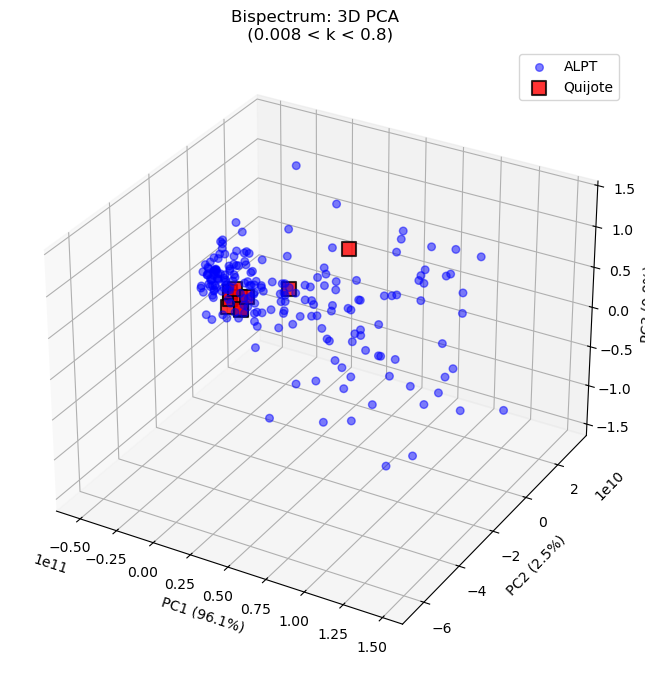

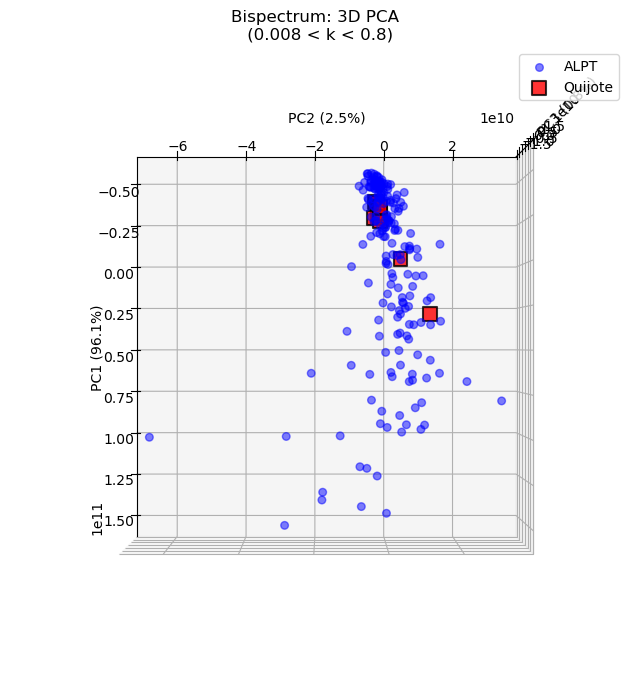

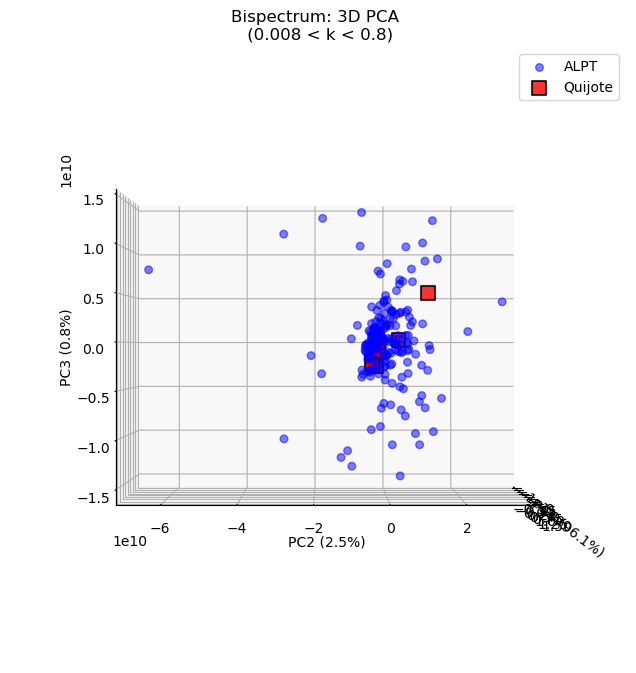

In [85]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot ALPT samples
ax.scatter(X_b0_pca[:200, 0], X_b0_pca[:200, 1], X_b0_pca[:200, 2],
           c='blue', alpha=0.5, s=30, label='ALPT')

# Plot Quijote samples
ax.scatter(X_b0_pca[200:, 0], X_b0_pca[200:, 1], X_b0_pca[200:, 2],
           c='red', alpha=0.8, s=100, marker='s', 
           edgecolors='black', linewidths=1.5, label='Quijote')

ax.set_xlabel(f'PC1 ({pca_b0.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_b0.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_b0.explained_variance_ratio_[2]:.1%})')
ax.set_title(f'Bispectrum: 3D PCA \n ({kmin} < k < {kmax})')
ax.legend()
plt.show()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot ALPT samples
ax.scatter(X_b0_pca[:200, 0], X_b0_pca[:200, 1], X_b0_pca[:200, 2],
           c='blue', alpha=0.5, s=30, label='ALPT')

# Plot Quijote samples
ax.scatter(X_b0_pca[200:, 0], X_b0_pca[200:, 1], X_b0_pca[200:, 2],
           c='red', alpha=0.8, s=100, marker='s', 
           edgecolors='black', linewidths=1.5, label='Quijote')

ax.set_xlabel(f'PC1 ({pca_b0.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_b0.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_b0.explained_variance_ratio_[2]:.1%})')
ax.set_title(f'Bispectrum: 3D PCA \n ({kmin} < k < {kmax})')
ax.legend()

ax.view_init(elev=90, azim=0)
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot ALPT samples
ax.scatter(X_b0_pca[:200, 0], X_b0_pca[:200, 1], X_b0_pca[:200, 2],
           c='blue', alpha=0.5, s=30, label='ALPT')

# Plot Quijote samples
ax.scatter(X_b0_pca[200:, 0], X_b0_pca[200:, 1], X_b0_pca[200:, 2],
           c='red', alpha=0.8, s=100, marker='s', 
           edgecolors='black', linewidths=1.5, label='Quijote')

ax.set_xlabel(f'PC1 ({pca_b0.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_b0.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_b0.explained_variance_ratio_[2]:.1%})')
ax.set_title(f'Bispectrum: 3D PCA \n ({kmin} < k < {kmax})')
ax.legend()
ax.view_init(elev=0, azim=0)
plt.show()

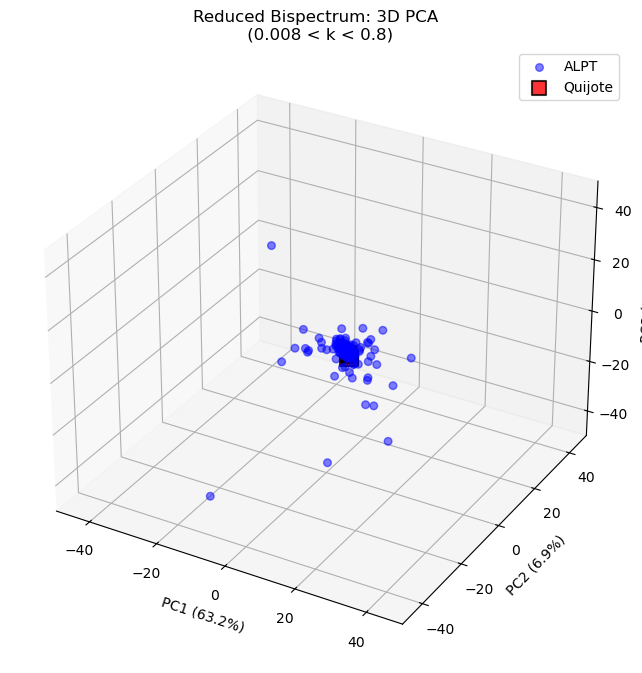

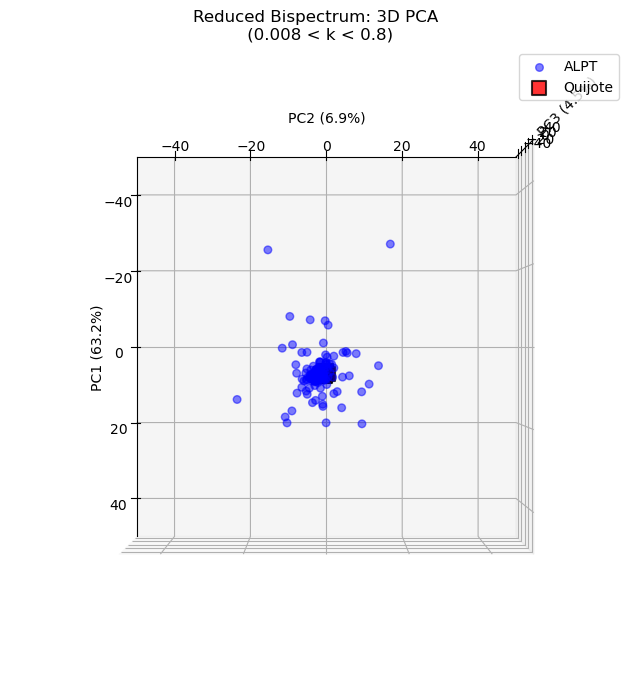

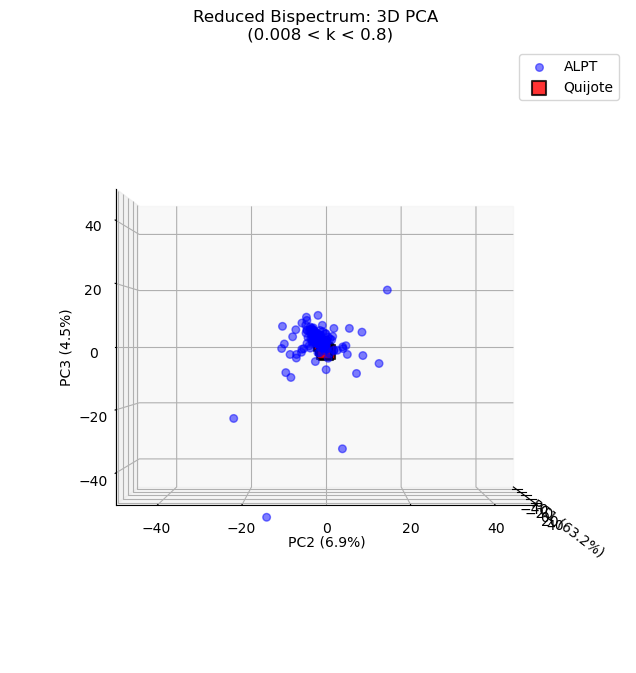

In [86]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot ALPT samples
ax.scatter(X_q0_pca[:200, 0], X_q0_pca[:200, 1], X_q0_pca[:200, 2],
           c='blue', alpha=0.5, s=30, label='ALPT')

# Plot Quijote samples
ax.scatter(X_q0_pca[200:, 0], X_q0_pca[200:, 1], X_q0_pca[200:, 2],
           c='red', alpha=0.8, s=100, marker='s', 
           edgecolors='black', linewidths=1.5, label='Quijote')

ax.set_xlabel(f'PC1 ({pca_q0.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_q0.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_q0.explained_variance_ratio_[2]:.1%})')
ax.set_title(f'Reduced Bispectrum: 3D PCA \n ({kmin} < k < {kmax})')
ax.legend()
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)
ax.set_zlim(-50,50)
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot ALPT samples
ax.scatter(X_q0_pca[:200, 0], X_q0_pca[:200, 1], X_q0_pca[:200, 2],
           c='blue', alpha=0.5, s=30, label='ALPT')

# Plot Quijote samples
ax.scatter(X_q0_pca[200:, 0], X_q0_pca[200:, 1], X_q0_pca[200:, 2],
           c='red', alpha=0.8, s=100, marker='s', 
           edgecolors='black', linewidths=1.5, label='Quijote')

ax.set_xlabel(f'PC1 ({pca_q0.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_q0.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_q0.explained_variance_ratio_[2]:.1%})')
ax.set_title(f'Reduced Bispectrum: 3D PCA \n ({kmin} < k < {kmax})')
ax.legend()
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)
ax.set_zlim(-50,50)
ax.view_init(elev=90, azim=0)
plt.show()


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot ALPT samples
ax.scatter(X_q0_pca[:200, 0], X_q0_pca[:200, 1], X_q0_pca[:200, 2],
           c='blue', alpha=0.5, s=30, label='ALPT')

# Plot Quijote samples
ax.scatter(X_q0_pca[200:, 0], X_q0_pca[200:, 1], X_q0_pca[200:, 2],
           c='red', alpha=0.8, s=100, marker='s', 
           edgecolors='black', linewidths=1.5, label='Quijote')

ax.set_xlim(-50,50)
ax.set_ylim(-50,50)
ax.set_zlim(-50,50)
ax.set_xlabel(f'PC1 ({pca_q0.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_q0.explained_variance_ratio_[1]:.1%})')
ax.set_zlabel(f'PC3 ({pca_q0.explained_variance_ratio_[2]:.1%})')
ax.set_title(f'Reduced Bispectrum: 3D PCA \n ({kmin} < k < {kmax})')
ax.legend()
ax.view_init(elev=0, azim=0)
plt.show()

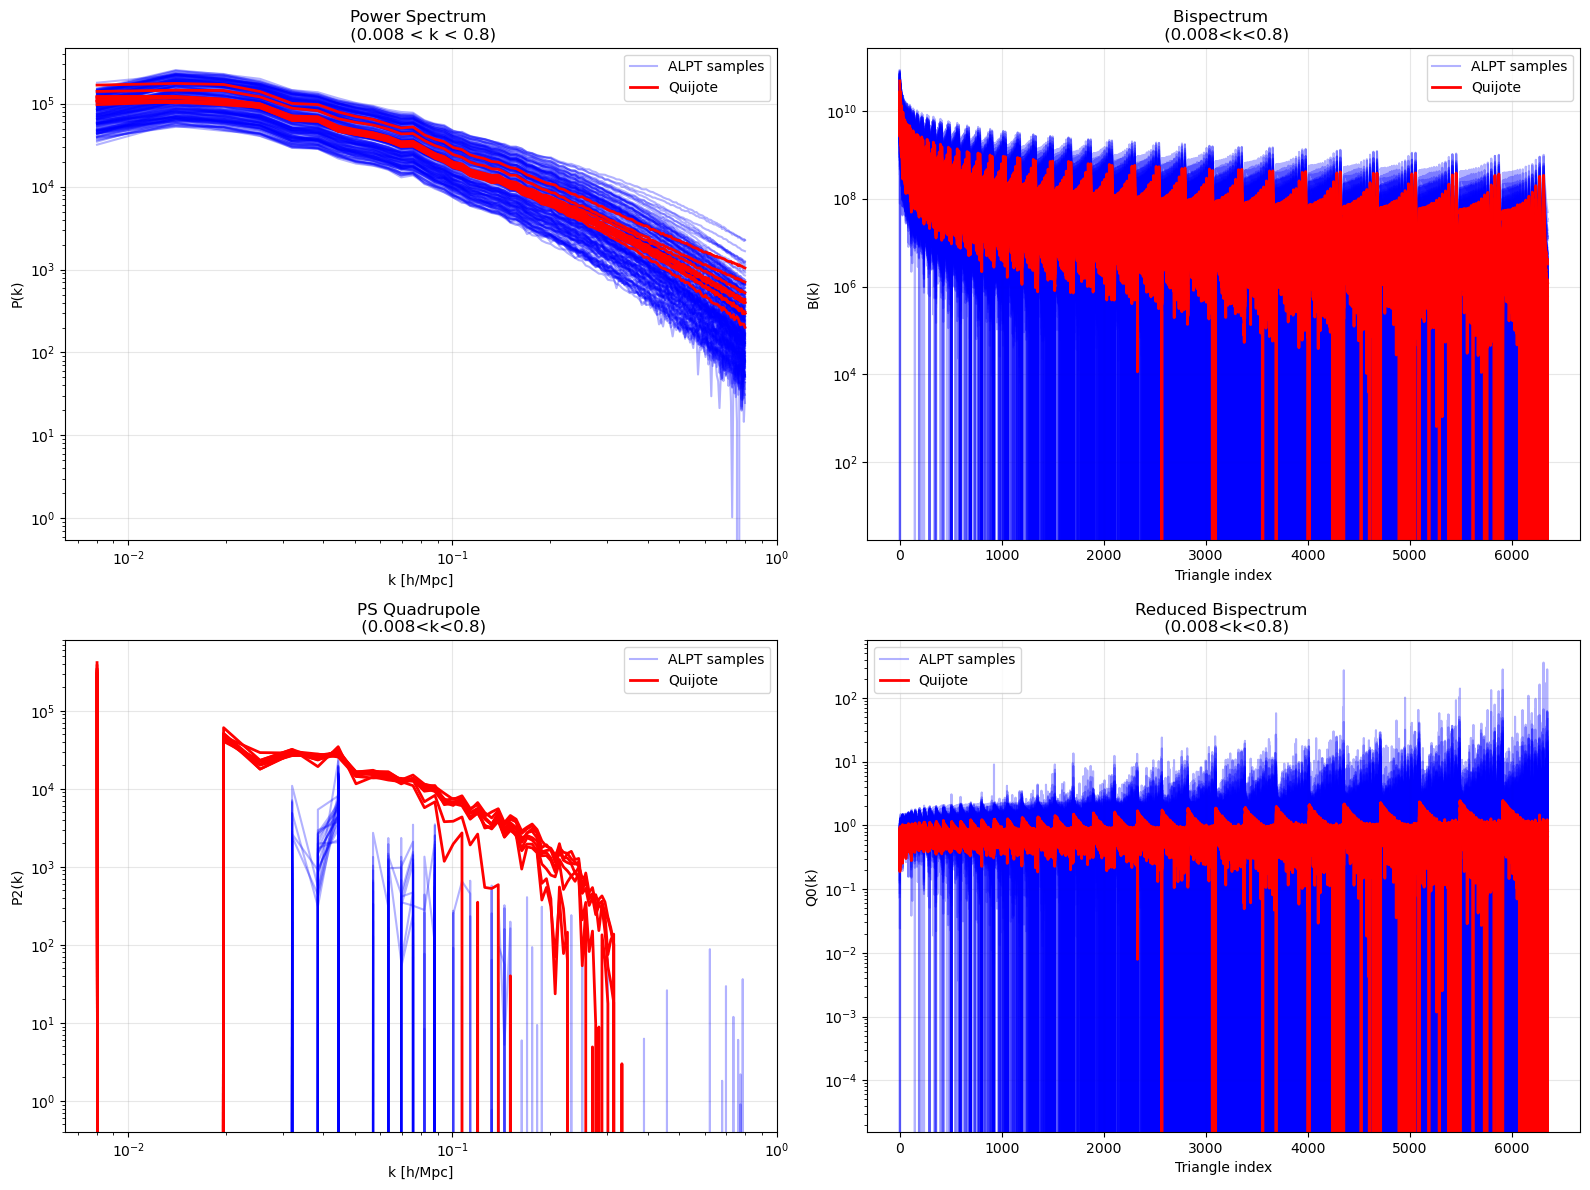

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
# with h5py.File('/Users/mcc3842/CosmicSim2025/alpt_hod_results.h5', 'r') as f:
#     k = f['sample_0/spec/k'][:78]
k = k_bins
# Power spectrum comparison
axes[0].loglog(k, alpt_pk[0], 'b-', alpha=0.3, label='ALPT samples')
for i in range(1, 200):
    axes[0].loglog(k, alpt_pk[i], 'b-', alpha=0.3)

for i in range(10):
    axes[0].loglog(k, quijote_pk[i], 'r-', linewidth=2, 
                   label='Quijote' if i == 0 else '')

axes[0].set_xlabel('k [h/Mpc]')
axes[0].set_ylabel('P(k)')
axes[0].set_title(f'Power Spectrum \n ({kmin} < k < {kmax})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bispectrum comparison
axes[1].plot(range(alpt_b0.shape[1]), alpt_b0[0], 'b-', alpha=0.3, label='ALPT samples')
for i in range(1, 200):
    axes[1].plot(range(alpt_b0.shape[1]), alpt_b0[i], 'b-', alpha=0.3)

for i in range(10):
    axes[1].plot(range(quijote_b0.shape[1]), quijote_b0[i], 'r-', linewidth=2,
                 label='Quijote' if i == 0 else '')

axes[1].set_xlabel('Triangle index')
axes[1].set_ylabel('B(k)')
axes[1].set_title(f'Bispectrum \n ({kmin}<k<{kmax})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

# PS Quadrupole comp
axes[2].loglog(k, alpt_p2k[0], 'b-', alpha=0.3, label='ALPT samples')
for i in range(1, 200):
    axes[2].loglog(k, alpt_p2k[i], 'b-', alpha=0.3)

for i in range(10):
    axes[2].loglog(k, quijote_p2k[i], 'r-', linewidth=2,
                 label='Quijote' if i == 0 else '')

axes[2].set_xlabel('k [h/Mpc]')
axes[2].set_ylabel('P2(k)')
axes[2].set_title(f'PS Quadrupole \n ({kmin}<k<{kmax})')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
# axes[2].set_yscale('log')

# reduced bispectrum
axes[3].plot(range(alpt_q0.shape[1]), alpt_q0[0], 'b-', alpha=0.3, label='ALPT samples')
for i in range(1, 200):
    axes[3].plot(range(alpt_q0.shape[1]), alpt_q0[i], 'b-', alpha=0.3)

for i in range(10):
    axes[3].plot(range(quijote_q0.shape[1]), quijote_q0[i], 'r-', linewidth=2,
                 label='Quijote' if i == 0 else '')

axes[3].set_xlabel('Triangle index')
axes[3].set_ylabel('Q0(k)')
axes[3].set_title(f'Reduced Bispectrum \n ({kmin}<k<{kmax})')
axes[3].legend()
axes[3].grid(True, alpha=0.3)
axes[3].set_yscale('log')

plt.tight_layout()
plt.show()


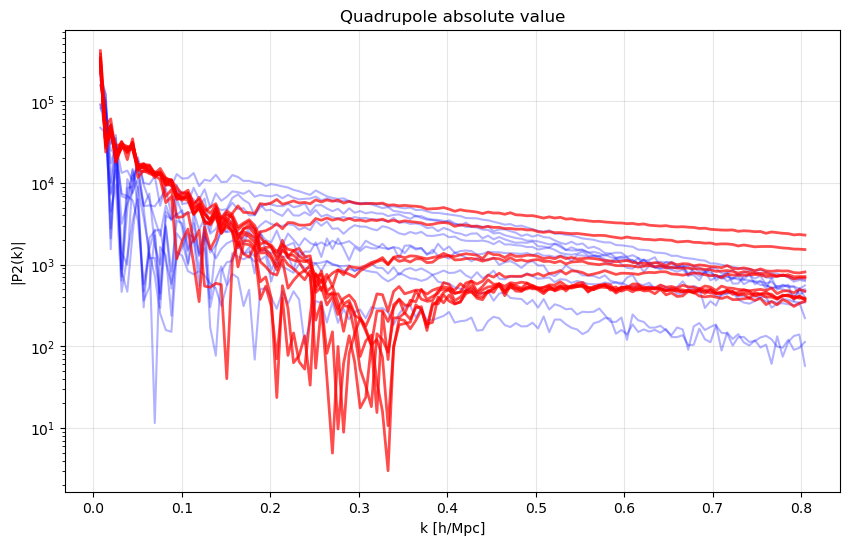

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(10):
    with h5py.File('/Users/mcc3842/CosmicSim2025/alpt_hod_results.h5', 'r') as f:
        p2k = f[f'sample_{i}/spec/p2k'][:]
        k = f['sample_0/spec/k'][:]
    ax.semilogy(k, np.abs(p2k), 'b-', alpha=0.3)

for i in range(10):
    with h5py.File('/Users/mcc3842/CosmicSim2025/quijote_hod_results.h5', 'r') as f:
        p2k = f[f'sample_{i}/spec/p2k'][:]
    ax.semilogy(k, np.abs(p2k), 'r-', linewidth=2, alpha=0.7)

ax.set_xlabel('k [h/Mpc]')
ax.set_ylabel('|P2(k)|')
ax.set_title('Quadrupole absolute value')
ax.grid(True, alpha=0.3)
plt.show()

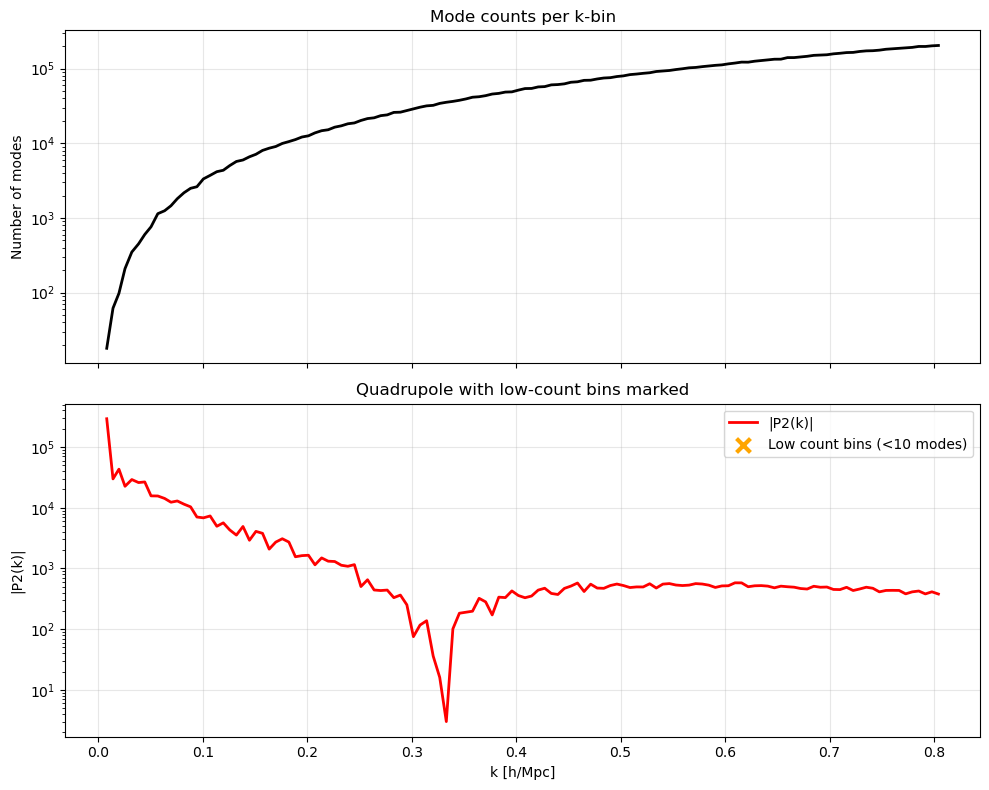

Bins with <10 modes: 0
Bins with <5 modes: 0


In [40]:
# 1. Check counts in k-bins - are certain bins nearly empty?
with h5py.File('/Users/mcc3842/CosmicSim2025/quijote_hod_results.h5', 'r') as f:
    counts = f['sample_0/spec/counts'][:]
    k = f['sample_0/spec/k'][:]
    p2k = f['sample_0/spec/p2k'][:]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot counts
axes[0].plot(k, counts, 'k-', linewidth=2)
axes[0].set_ylabel('Number of modes')
axes[0].set_title('Mode counts per k-bin')
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Plot quadrupole with spikes highlighted
axes[1].semilogy(k, np.abs(p2k), 'r-', linewidth=2, label='|P2(k)|')
# Mark bins with low counts
low_count_mask = counts < 10  # Adjust threshold
axes[1].scatter(k[low_count_mask], np.abs(p2k[low_count_mask]), 
                c='orange', s=100, marker='x', linewidths=3, 
                label=f'Low count bins (<10 modes)', zorder=5)
axes[1].set_xlabel('k [h/Mpc]')
axes[1].set_ylabel('|P2(k)|')
axes[1].set_title('Quadrupole with low-count bins marked')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Bins with <10 modes: {np.sum(counts < 10)}")
print(f"Bins with <5 modes: {np.sum(counts < 5)}")

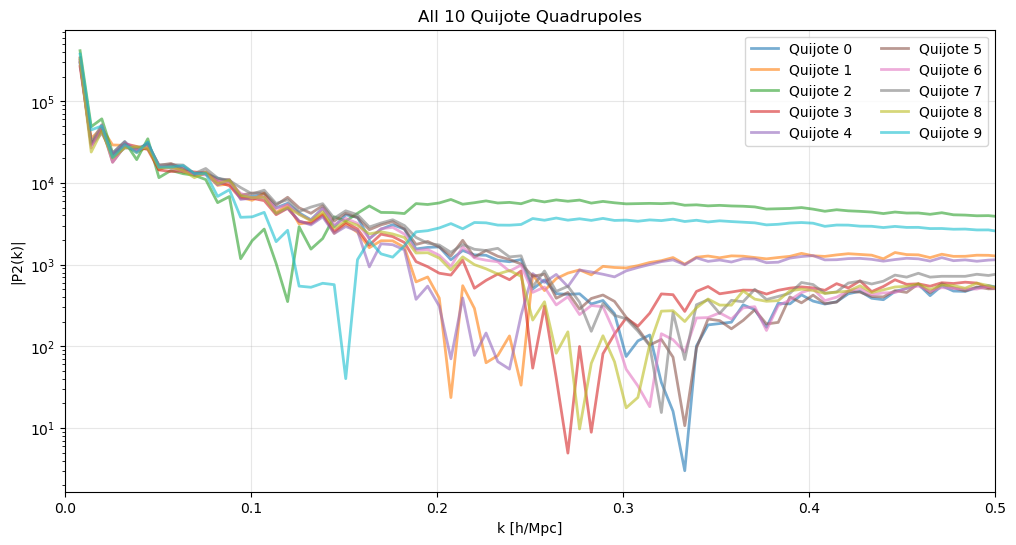


At k ≈ 0.35 (index 55):
  k = 0.3519
  counts = 39294.0

Fundamental mode: k_fund = 0.006283
k / k_fund at spike: 56.0


In [41]:
# Check if all Quijote samples have the same spike pattern
fig, ax = plt.subplots(figsize=(12, 6))

# Plot all 10 Quijote quadrupoles
for i in range(10):
    with h5py.File('/Users/mcc3842/CosmicSim2025/quijote_hod_results.h5', 'r') as f:
        k = f['sample_0/spec/k'][:]
        p2k = f[f'sample_{i}/spec/p2k'][:]
        counts = f[f'sample_{i}/spec/counts'][:]
    
    ax.semilogy(k, np.abs(p2k), linewidth=2, alpha=0.6, label=f'Quijote {i}')

ax.set_xlabel('k [h/Mpc]')
ax.set_ylabel('|P2(k)|')
ax.set_title('All 10 Quijote Quadrupoles')
ax.legend(ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 0.5)
plt.show()

# Check k-values at the spike
spike_idx = np.argmin(np.abs(k - 0.35))
print(f"\nAt k ≈ 0.35 (index {spike_idx}):")
print(f"  k = {k[spike_idx]:.4f}")
print(f"  counts = {counts[spike_idx]}")

# Check if it's exactly at k_fundamental or a harmonic
box_size = 1000  # Mpc/h (you mentioned this earlier)
k_fund = 2 * np.pi / box_size
print(f"\nFundamental mode: k_fund = {k_fund:.6f}")
print(f"k / k_fund at spike: {k[spike_idx] / k_fund:.1f}")

In [43]:
# Check if P(k,mu) is smooth but quadrupole is spiky
with h5py.File('/Users/mcc3842/CosmicSim2025/quijote_hod_results.h5', 'r') as f:
    for i in [0, 2, 3]:  # Samples with visible spikes
        p_kmu = f[f'sample_{i}/spec/p_kmu'][:]
        p2k = f[f'sample_{i}/spec/p2k'][:]
        k = f['sample_0/spec/k'][:]
        ""
        print(f"\nSample {i}:")
        print(f"  P(k,μ) has NaNs: {np.sum(np.isnan(p_kmu))}")
        print(f"  P(k,μ) has zeros: {np.sum(p_kmu == 0)}")
        print(f"  P2(k) has NaNs: {np.sum(np.isnan(p2k))}")
        print(f"  P2(k) min value: {np.min(p2k):.2e}")
        
        # Find the spike
        spike_idx = np.argmin(p2k)
        print(f"  Spike at k = {k[spike_idx]:.4f}, P2(k) = {p2k[spike_idx]:.2e}")


Sample 0:
  P(k,μ) has NaNs: 0
  P(k,μ) has zeros: 0
  P2(k) has NaNs: 0
  P2(k) min value: -2.99e+04
  Spike at k = 0.0140, P2(k) = -2.99e+04

Sample 2:
  P(k,μ) has NaNs: 0
  P(k,μ) has zeros: 0
  P2(k) has NaNs: 0
  P2(k) min value: -4.89e+04
  Spike at k = 0.0140, P2(k) = -4.89e+04

Sample 3:
  P(k,μ) has NaNs: 0
  P(k,μ) has zeros: 0
  P2(k) has NaNs: 0
  P2(k) min value: -3.05e+04
  Spike at k = 0.0140, P2(k) = -3.05e+04


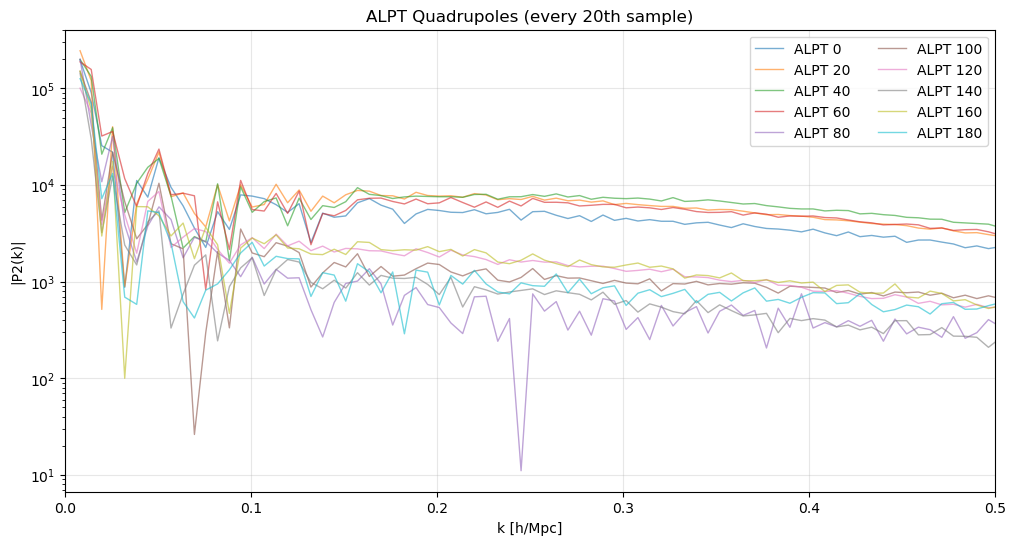


Checking for spikes in ALPT quadrupoles:
No systematic spikes detected in ALPT


In [42]:
# Plot all 200 ALPT quadrupoles
fig, ax = plt.subplots(figsize=(12, 6))

with h5py.File('/Users/mcc3842/CosmicSim2025/alpt_hod_results.h5', 'r') as f:
    k = f['sample_0/spec/k'][:]
    
    # Plot a subset for visibility (all 200 would be too messy)
    for i in range(0, 200, 20):  # Every 20th sample
        p2k = f[f'sample_{i}/spec/p2k'][:]
        ax.semilogy(k, np.abs(p2k), linewidth=1, alpha=0.6, label=f'ALPT {i}')

ax.set_xlabel('k [h/Mpc]')
ax.set_ylabel('|P2(k)|')
ax.set_title('ALPT Quadrupoles (every 20th sample)')
ax.legend(ncol=2)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 0.5)
plt.show()

# Check for systematic spikes at specific k values
print("\nChecking for spikes in ALPT quadrupoles:")
with h5py.File('/Users/mcc3842/CosmicSim2025/alpt_hod_results.h5', 'r') as f:
    k = f['sample_0/spec/k'][:]
    
    # Collect all quadrupoles
    all_p2k = np.zeros((200, len(k)))
    for i in range(200):
        all_p2k[i] = np.abs(f[f'sample_{i}/spec/p2k'][:])
    
    # Compute median and look for outliers
    median_p2k = np.median(all_p2k, axis=0)
    std_p2k = np.std(all_p2k, axis=0)
    
    # Flag k-bins where many samples have huge deviations
    spike_bins = np.where(std_p2k / median_p2k > 5)[0]  # CV > 500%
    
    if len(spike_bins) > 0:
        print(f"Found {len(spike_bins)} suspicious k-bins with high variance:")
        for idx in spike_bins[:10]:  # Show first 10
            k_fund = 2 * np.pi / 1000.
            print(f"  k = {k[idx]:.4f}, k/k_fund = {k[idx]/k_fund:.1f}")
    else:
        print("No systematic spikes detected in ALPT")

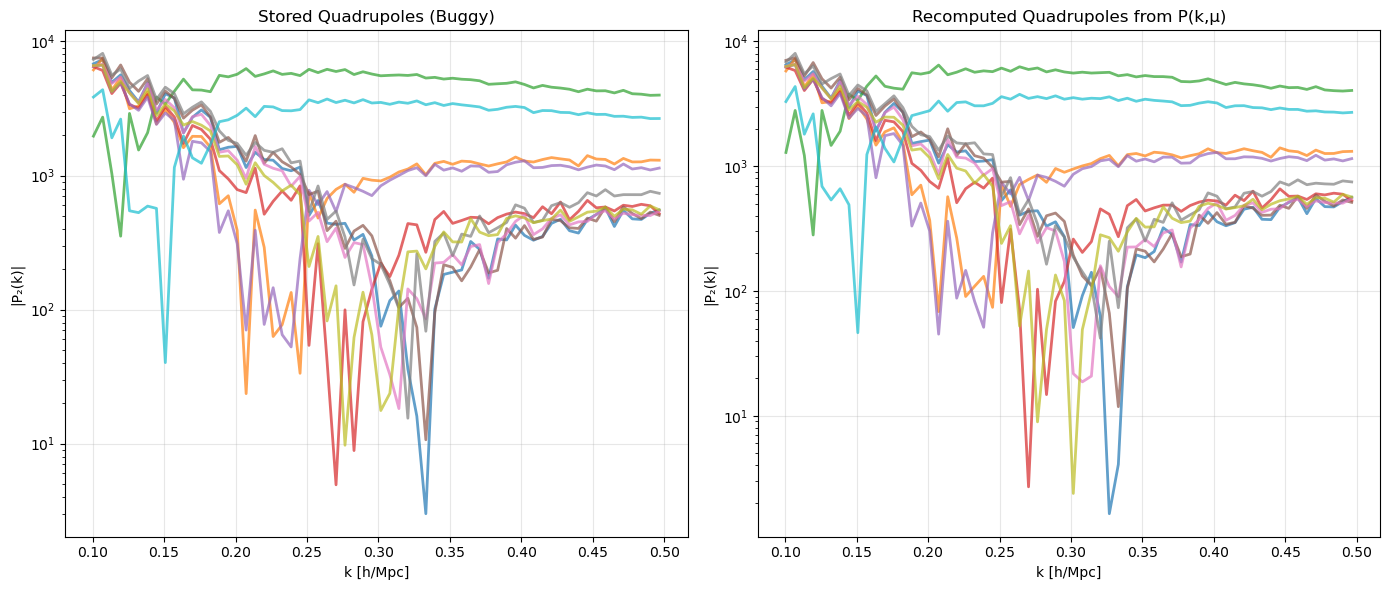

In [51]:


def compute_multipoles_from_pkmu(p_kmu, mu_kmu):
    """Compute multipoles from P(k,mu) using Legendre polynomials"""
    L2 = 0.5 * (3 * mu_kmu**2 - 1)  # Quadrupole Legendre polynomial
    p2k_recomputed = 5 * np.mean(p_kmu * L2, axis=1)  # (2*2+1) = 5
    return p2k_recomputed

# Quick comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

with h5py.File('/Users/mcc3842/CosmicSim2025/quijote_hod_results.h5', 'r') as f:
    k = f['sample_0/spec/k'][:]
    k_mask = (k >= 0.1) & (k <= 0.5)
    
    # Left: Stored (buggy) quadrupoles
    for i in range(10):
        p2k_stored = f[f'sample_{i}/spec/p2k'][:]
        axes[0].semilogy(k[k_mask], np.abs(p2k_stored[k_mask]), 
                        linewidth=2, alpha=0.7)
    
    # Right: Recomputed quadrupoles
    for i in range(10):
        p_kmu = f[f'sample_{i}/spec/p_kmu'][:]
        mu_kmu = f[f'sample_{i}/spec/mu_kmu'][:]
        p2k_new = compute_multipoles_from_pkmu(p_kmu, mu_kmu)
        axes[1].semilogy(k[k_mask], np.abs(p2k_new[k_mask]), 
                        linewidth=2, alpha=0.7)

axes[0].set_xlabel('k [h/Mpc]')
axes[0].set_ylabel('|P₂(k)|')
axes[0].set_title('Stored Quadrupoles (Buggy)')
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('k [h/Mpc]')
axes[1].set_ylabel('|P₂(k)|')
axes[1].set_title('Recomputed Quadrupoles from P(k,μ)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

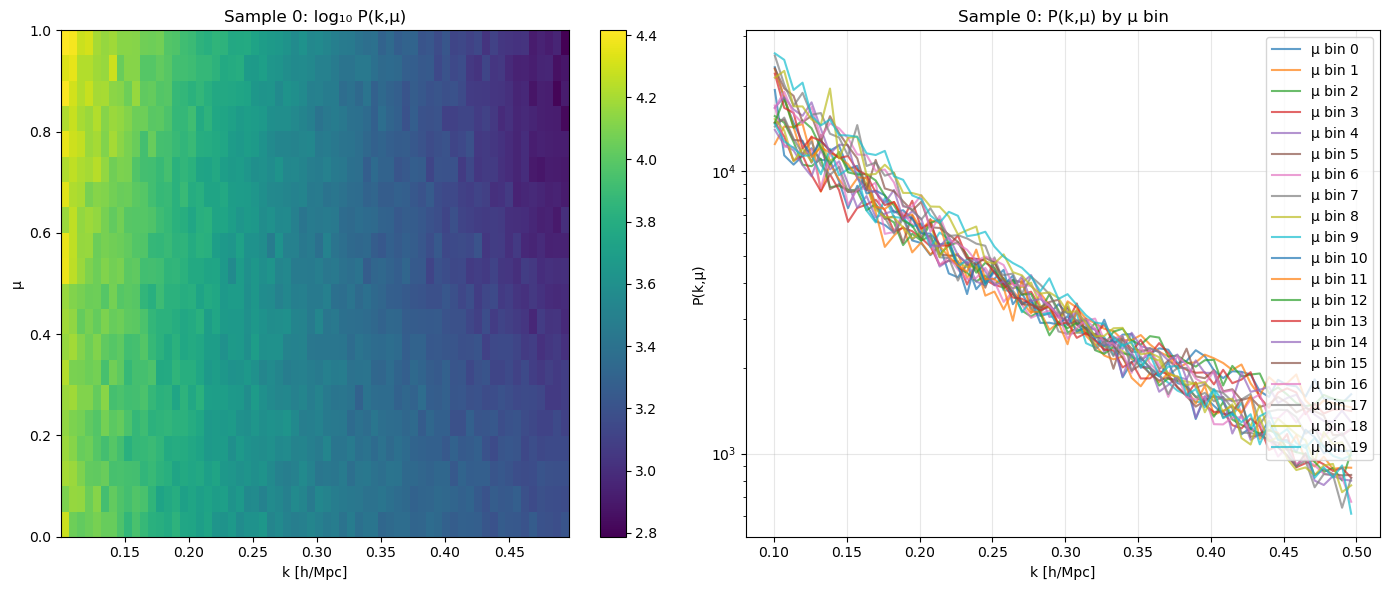

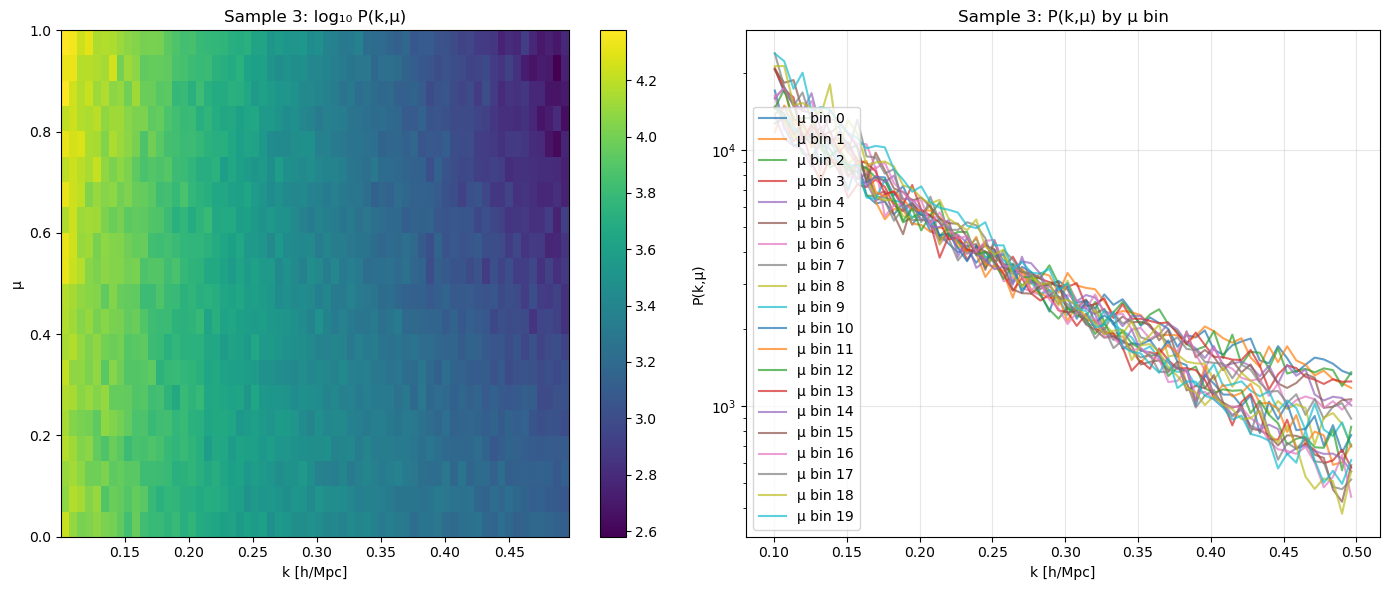

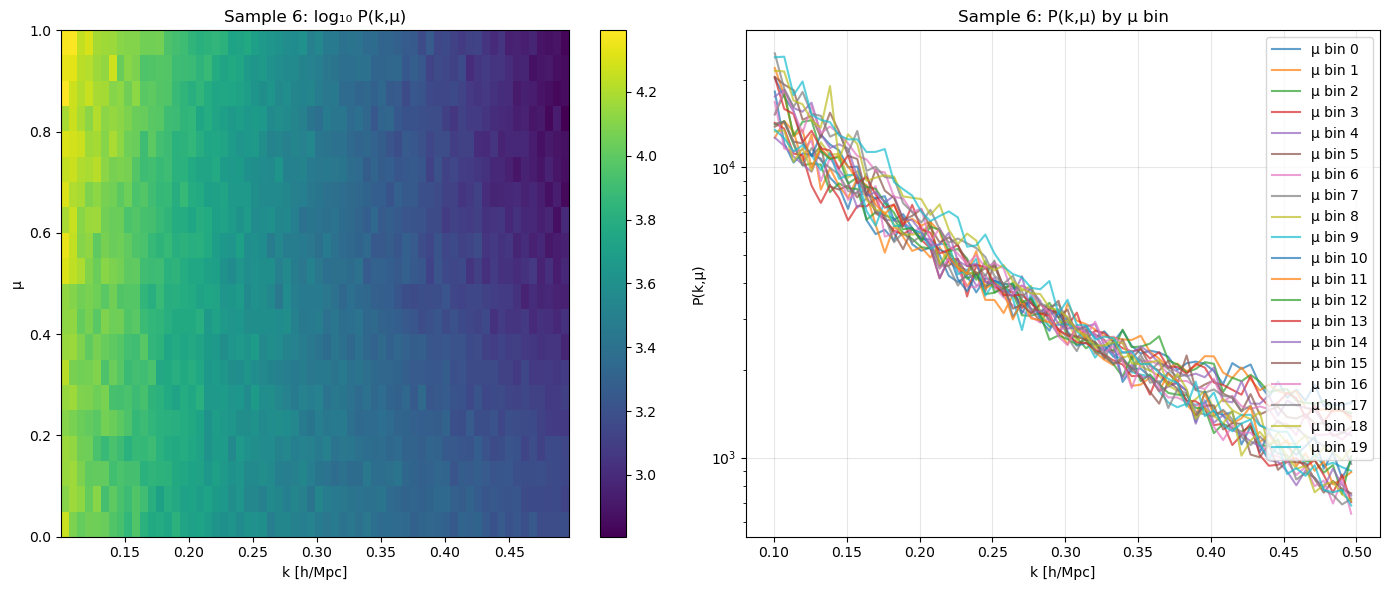


Checking variance across mu bins:


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'simulation_results.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [52]:


# Check P(k,mu) directly
with h5py.File('/Users/mcc3842/CosmicSim2025/quijote_hod_results.h5', 'r') as f:
    k = f['sample_0/spec/k'][:]
    k_mask = (k >= 0.1) & (k <= 0.5)
    
    # Look at a few samples
    for sample_idx in [0, 3, 6]:
        p_kmu = f[f'sample_{sample_idx}/spec/p_kmu'][:]
        mu_kmu = f[f'sample_{sample_idx}/spec/mu_kmu'][:]
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Left: P(k,mu) as heatmap
        im = axes[0].imshow(np.log10(p_kmu[k_mask, :]).T, 
                           aspect='auto', origin='lower',
                           extent=[k[k_mask].min(), k[k_mask].max(), 0, 1],
                           cmap='viridis')
        axes[0].set_xlabel('k [h/Mpc]')
        axes[0].set_ylabel('μ')
        axes[0].set_title(f'Sample {sample_idx}: log₁₀ P(k,μ)')
        plt.colorbar(im, ax=axes[0])
        
        # Right: P(k,mu) for different mu bins
        n_mu_bins = p_kmu.shape[1]
        for j in range(n_mu_bins):
            axes[1].semilogy(k[k_mask], p_kmu[k_mask, j], 
                           alpha=0.7, label=f'μ bin {j}')
        
        axes[1].set_xlabel('k [h/Mpc]')
        axes[1].set_ylabel('P(k,μ)')
        axes[1].set_title(f'Sample {sample_idx}: P(k,μ) by μ bin')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Check if specific mu bins have problems
print("\nChecking variance across mu bins:")
with h5py.File('simulation_results.h5', 'r') as f:
    for i in range(10):
        p_kmu = f[f'sample_{i}/spec/p_kmu'][:]
        
        # Check if any mu bins have huge spikes
        for j in range(p_kmu.shape[1]):
            ratio = p_kmu[:, j].max() / p_kmu[:, j].mean()
            if ratio > 100:
                print(f"Sample {i}, μ bin {j}: max/mean ratio = {ratio:.1f}")

In [3]:
# HOD for quijote 
theta_hod = {
    'logMmin': 13.06,
    'sigma_logM': 0.34,
    'logM0': 13.74,
    'logM1': 14.17,
    'alpha': 0.69,
    'Abias': 0.1, 
    'eta_conc': 1.12,
    'eta_cen': 0.3,
    'eta_sat': 1.26}
hod_quijote = Q.HODgalaxies(theta_hod,'/Users/mcc3842/CosmicSim2025/data/quijote/latin_hypercube_HR/100', z=0.5)
# get redshift-space positions
xyz_q = Q.Box_RSD(hod_quijote, LOS=[0,0,1], Lbox=1000.) # in z-direction
hod_Q_spec = stats.Pk_periodic(xyz_q.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)
k_bins_allk = hod_Q_spec['k']
P_nbody_allk = hod_Q_spec['p0k']

/Users/mcc3842/CosmicSim2025/hodalpt/src/hodalpt/sims/quijote.py:132: RuntimeWarning: divide by zero encountered in divide
  conc = rstar[:,3] / rstar[:,4]
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received mu

------------------
354989 positions in 1000 box
nbar = 0.000355
354989 positions, Ntot=354989
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---


In [4]:
k_bins = k_bins_allk[:78]
P_nbody = P_nbody_allk[:78]

In [5]:
xyz = CS.CSbox_alpt(fconfig, outdir, seed=0, make_ics=True, silent=False)

Computing and writing out delta IC
Computing displacement fields at z=0.5
Compiled with MULTITHREAD support, with 10 threads
 >>> web-on: initialising settings....

---> attention: N1= 256
---> attention: redshift= 0


 >>> starting web-on  ...

 >>> web-on initialising cosmological model....

number of chosen redshift snapshots = 1
... writing file posx.dat
... writing file posy.dat
... writing file posz.dat
... writing file posorx.dat
... writing file posory.dat
... writing file posorz.dat
... writing file posor0x.dat
... writing file posor0y.dat
... writing file posor0z.dat
... reading file Quijote_ICs_delta_z127_n256_CIC.DAT
... writing file deltaICOM0.313OL0.687G256V1000.0.dat
... writing file auxreal.dat
... writing file auxim.dat
 >>> dump power-spectrum in : pk_deltaICOM0.313OL0.687G256V1000.0.dat
-->  sample velocity;  z_min, z_max: 0.5  0.5 
... writing file VEZELDx.dat
... writing file VEZELDy.dat
... writing file VEZELDz.dat
-->  calculate values for: 1 snapshots
redshift=0

In [ ]:
# Least squares to fit ALPT to n-body powspec
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
# Starting parameters (CMASS best fit)
theta_gal = {
    'alpha': 1.9230,
    'beta': 2.0253,
    'dth': -0.7889,
    'rhoeps': 14.6874,
    'eps': 0.5616, 
    'nmean': 3.3e-4
}
theta_gal_fixed = {
    'dth': -0.7889,
    # 'nmean': 3.3e-4
}

theta_rsd = {
    'bv': 0.7289,
    'bb': 1.1652,
    'betarsd': 1.3136,
    'gamma': 0.4944
}
param_names = list(theta_gal.keys()) + list(theta_rsd.keys())
theta_init = np.array(list(theta_gal.values()) + list(theta_rsd.values()))

#bounds = [(val * 0.7, val * 1.3) if val > 0 else (val * 1.3, val * 0.7) 
          #for val in theta_init]

# custom bounds 
bounds = [(1.,3.5), (1.,3.5), (7.,21.), (0.1,0.9),(3.0e-4,2.0e-3), (0.35,1.05), (0.58,1.74),(0.65,1.95),(0.25,0.75)]
def run_alpt_and_measure_pk(theta_gal_dict, theta_rsd_dict):
    """
    Your function that:
    1. Takes parameter dictionary
    2. Runs ALPT simulation
    3. Measures P(k)
    4. Returns P_alpt at your k_bins
    """
    
    xyz_g = CS.CSbox_galaxy(theta_gal_dict, theta_rsd_dict, outdir, silent=True)
    alpt_spec = stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)
    kbins_alpt_allk = alpt_spec['k']
    P_alpt_allk = alpt_spec['p0k']
    return P_alpt_allk[:78]
    
# def params_array_to_dict(params_array):
#     """Convert parameter array back to dictionaries"""
#     theta_gal_new = {name: params_array[i] for i, name in enumerate(list(theta_gal.keys()))}
#     theta_rsd_new = {name: params_array[i+6] for i, name in enumerate(list(theta_rsd.keys()))}
#     return theta_gal_new, theta_rsd_new
def params_array_to_dict(params_array):
    """Convert parameter array back to dictionaries"""
    theta_gal_new = {name: params_array[i] for i, name in enumerate(list(theta_gal.keys()))}
    theta_gal_new.update(theta_gal_fixed)
    theta_rsd_new = {name: params_array[i+5] for i, name in enumerate(list(theta_rsd.keys()))}
    print(theta_gal_new,theta_rsd_new)
    return theta_gal_new, theta_rsd_new


def chi_squared(params_array):
    """Objective function for minimizer"""
    # Convert array to dictionaries
    theta_gal_new, theta_rsd_new = params_array_to_dict(params_array)
    
    # Run ALPT with these parameters
    P_alpt = run_alpt_and_measure_pk(theta_gal_new, theta_rsd_new)
    # Compute chi-squared (simple 1/P^2 weighting)
    # weights = 1.0 / P_nbody**2
    weights = 1.0/P_nbody
    chi2 = np.sum(weights * (P_nbody - P_alpt)**2)
    
    # logarithmic residuals 
    # chi2 = np.sum((np.log(P_nbody) - np.log(P_alpt))**2)
    
    print(f"χ² = {chi2:.2f}")  # Monitor progress
    return chi2
# Run optimization
# result = differential_evolution(
#     chi_squared,
#     bounds,
#     maxiter=50,           # Number of generations
#     popsize=10,           # Population size (10 * 9 params = 90 evaluations per generation)
#     workers=1,            # Parallel workers (set to 1 for now)
#     seed=42,              # Reproducibility
#     disp=True,            # Show progress
#     polish=False,         # Don't do final L-BFGS-B refinement (faster)
#     atol=0.01,            # Absolute tolerance
#     tol=0.01              # Relative tolerance
# )
result = minimize(
    chi_squared,
    theta_init,
    method='L-BFGS-B',  # Good for bounded optimization
    bounds=bounds,
    options={'ftol':1e-10, 'maxiter': 20}
)
theta_best = result.x
theta_gal_best, theta_rsd_best = params_array_to_dict(theta_best)

print("\nBest-fit parameters:")
print("Galaxy bias:", theta_gal_best)
print("RSD:", theta_rsd_best)
print(f"Final χ² = {result.fun:.2f}")

{'alpha': np.float64(1.923), 'beta': np.float64(2.0253), 'rhoeps': np.float64(14.6874), 'eps': np.float64(0.5616), 'nmean': np.float64(0.00033), 'dth': -0.7889} {'bv': np.float64(0.7289), 'bb': np.float64(1.1652), 'betarsd': np.float64(1.3136), 'gamma': np.float64(0.4944)}


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


-->Find starting indices ...
-->Start loop over cells of the mesh ...
------------------
330388 positions in 1000 box
nbar = 0.000330
330388 positions, Ntot=330388
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
χ² = 22283.00
{'alpha': np.float64(1.92300001), 'beta': np.float64(2.0253), 'rhoeps': np.float64(14.6874), 'eps': np.float64(0.5616), 'nmean': np.float64(0.00033), 'dth': -0.7889} {'bv': np.float64(0.7289), 'bb': np.float64(1.1652), 'betarsd': np.float64(1.3136), 'gamma': np.float64(0.4944)}
-->Find starting indices ...
-->Start loop over cells of the mesh ...
------------------
331129 positions in 1000 box
nbar = 0.000331
331129 positions, Ntot=331129
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
χ² = 22705.53
{'alpha': np.float64(1.923), 'beta': np.float64(2.02530001), 'rhoeps': np.float64(14.6874), 'eps': np.float64(0.5616), 'nmean': np.float64(0.00033), 'dth': -0.7889} {'bv': np.

OM0.313OL0.687G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.313000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 18.0 0.019667983055114746
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...
------------------
329974 positions in 1000 box
nbar = 0.000330
329974 positions, Ntot=329974
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---


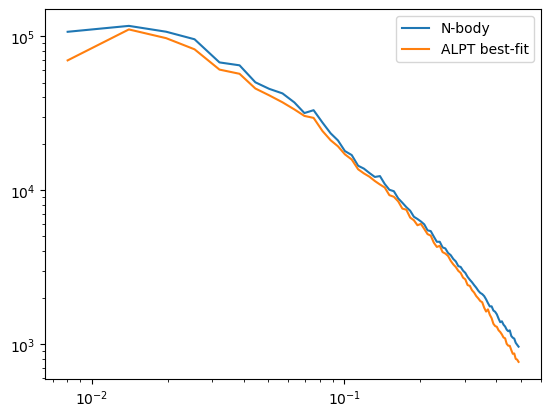

In [7]:
xyz_g = CS.CSbox_galaxy(theta_gal_best, theta_rsd_best, outdir, silent=False)
spec_bf = stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)
P_alpt_bf = spec_bf['p0k'][:78]

plt.loglog(k_bins, P_nbody, label='N-body')
plt.loglog(k_bins, P_alpt_bf, label='ALPT best-fit')
plt.legend()

In [8]:
# bipectrum comparison by eye 
quijote_bispec = stats.B0_periodic(xyz_q.T, w=None, Lbox=1000., fft='pyfftw', silent=True)
alpt_bispec = stats.B0_periodic(xyz_g.T, w=None, Lbox=1000., fft='pyfftw', silent=True)

array([ True,  True,  True, ..., False, False, False], shape=(6350,))

Text(0.5, 0, '$k_1 < k_2 < k_3$ triangles, k<0.5')

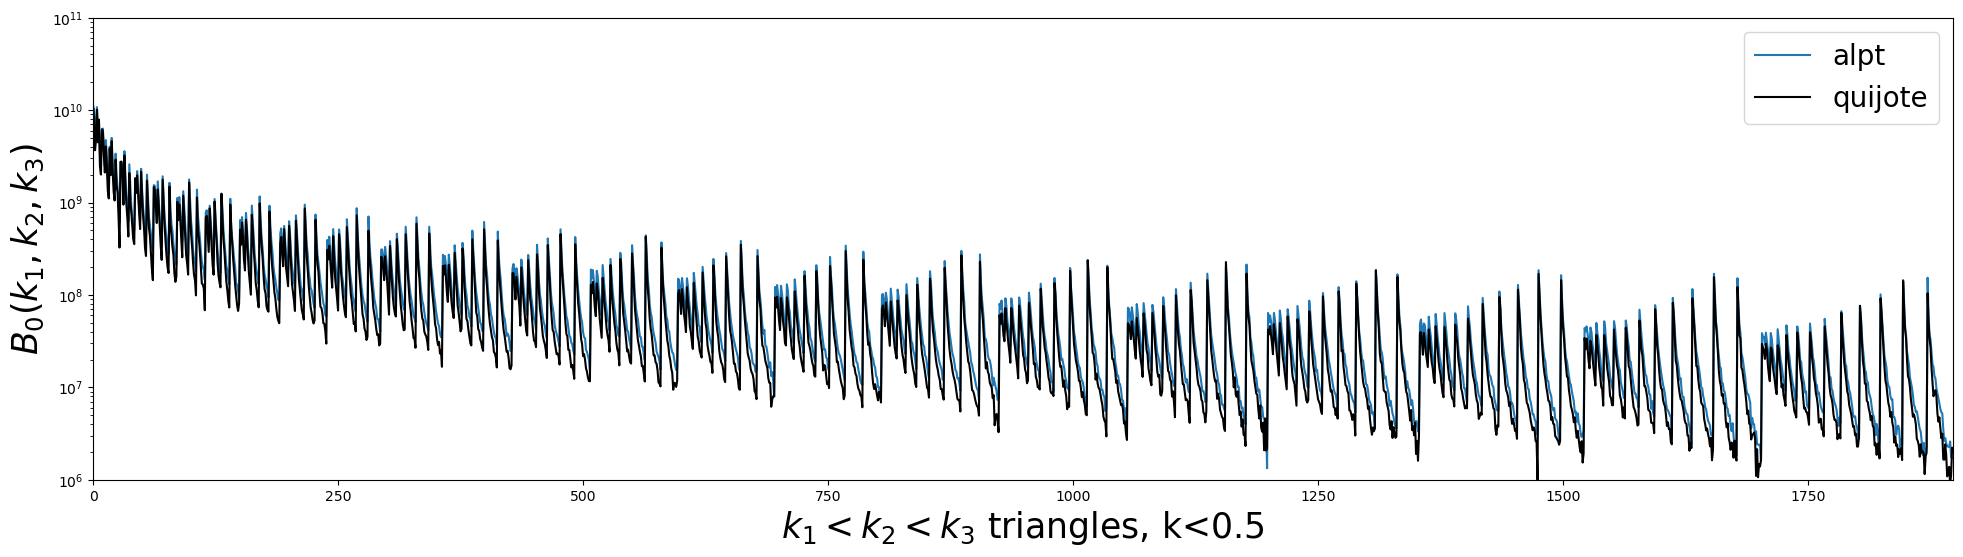

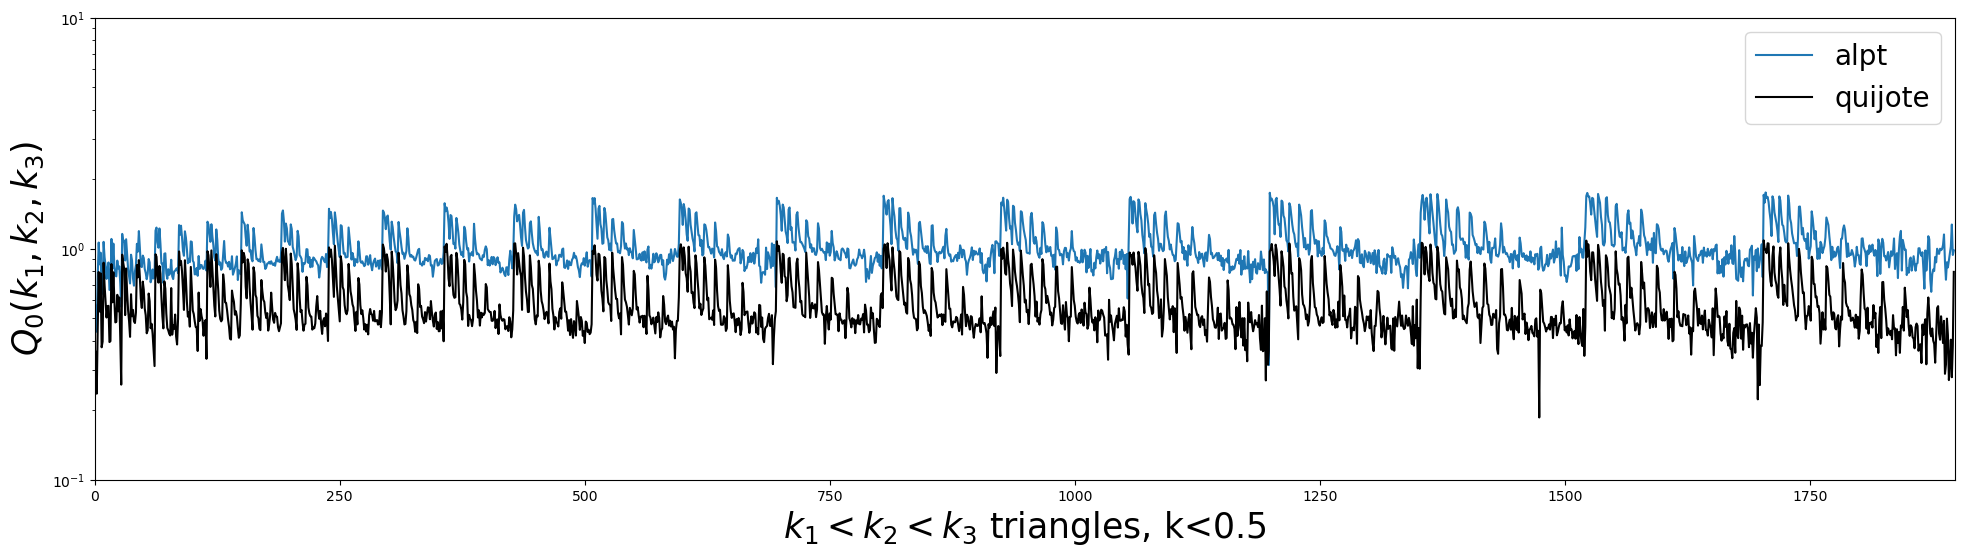

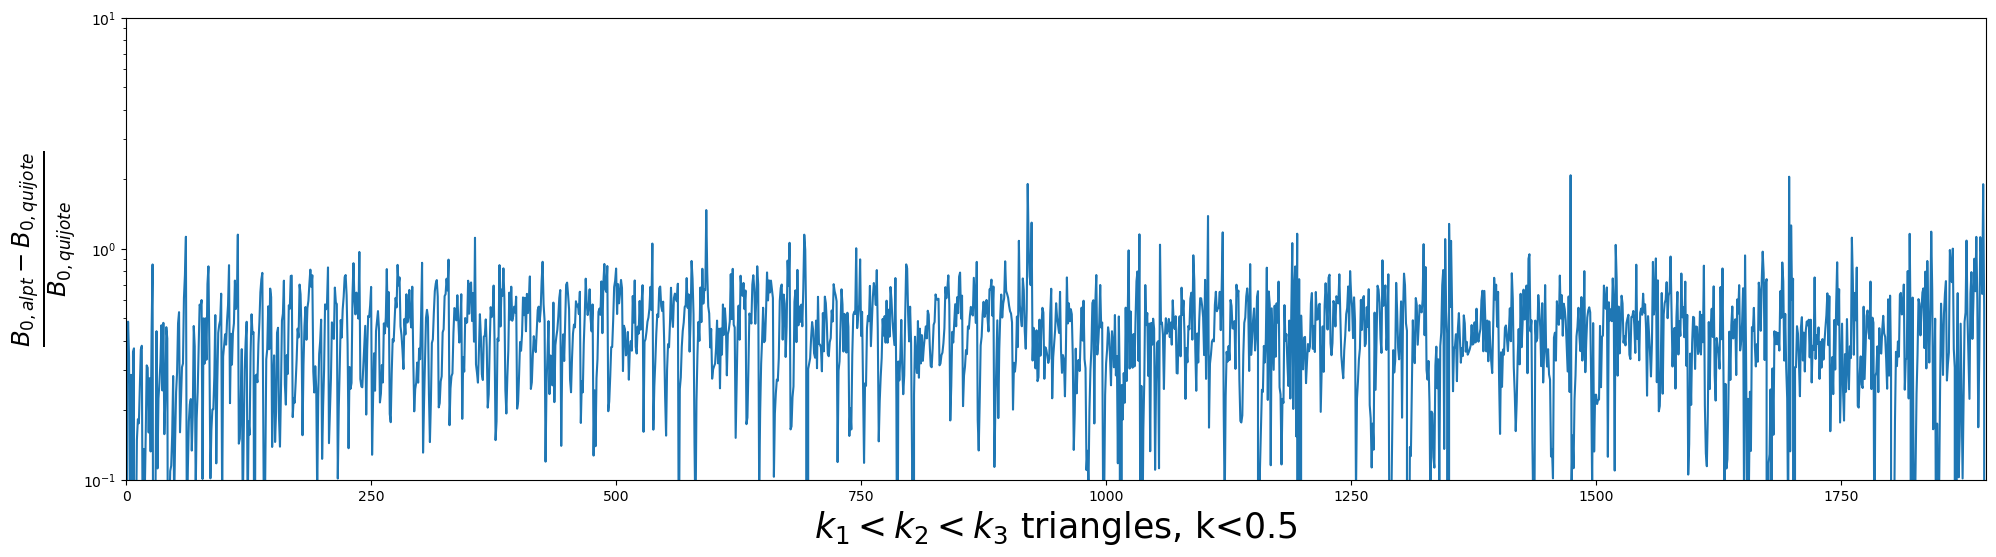

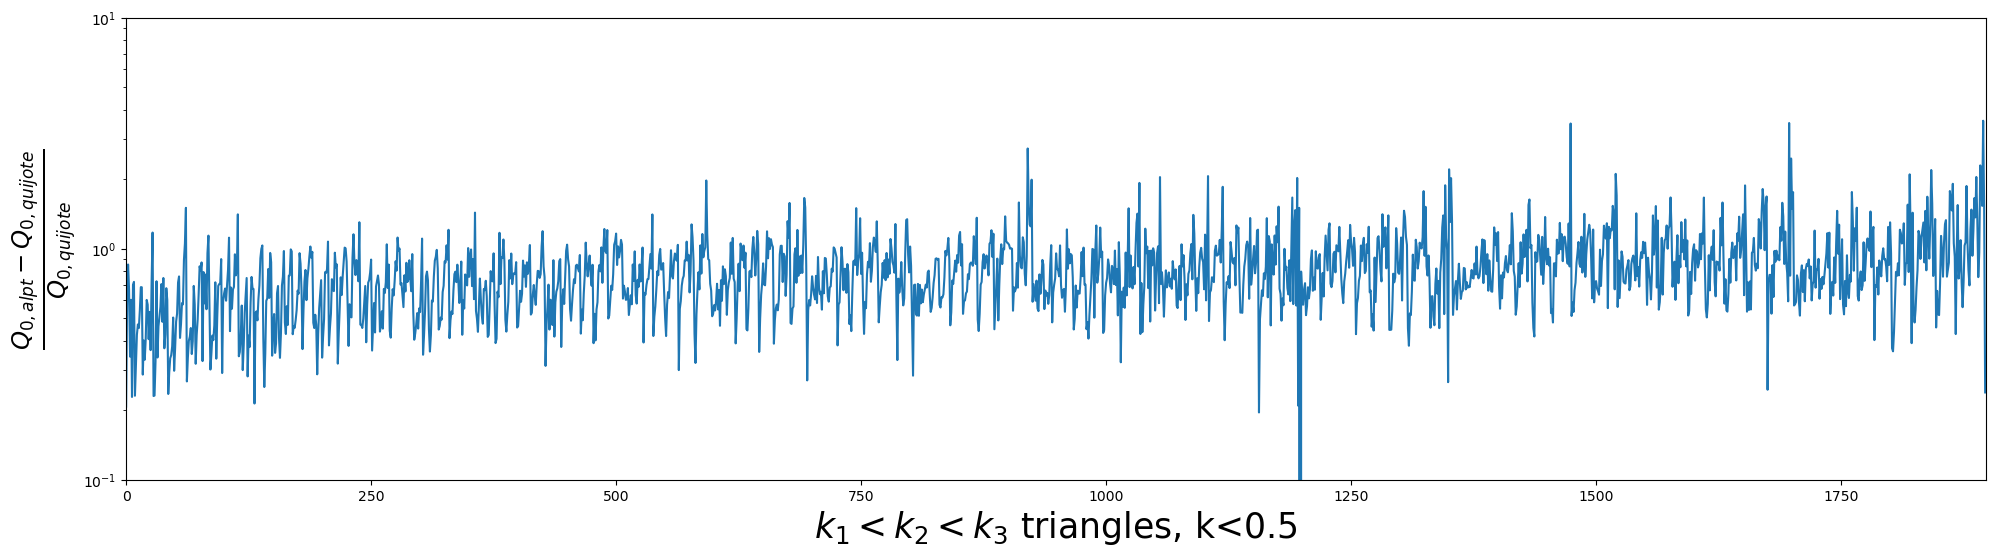

In [ ]:
i_k1 = alpt_bispec['i_k1']
i_k2 = alpt_bispec['i_k2']
i_k3 = alpt_bispec['i_k3']

k_fund = 2 * np.pi / 1000.

k1 = i_k1 * k_fund
k2 = i_k2 * k_fund
k3 = i_k3 * k_fund

b123_alpt = alpt_bispec['b123']
b123_quijote = quijote_bispec['b123']


klim = (k1 < 0.5) & (k2 < 0.5) & (k3 < 0.5)

q123_alpt = alpt_bispec['q123']
q123_quijote = quijote_bispec['q123']



fig = plt.figure(figsize=(24,6))
sub = fig.add_subplot(111)


sub.plot(range(np.sum(klim)), b123_alpt[klim], color='C0', label='alpt')
sub.plot(range(np.sum(klim)), b123_quijote[klim], color='black', label='quijote')
sub.set_ylabel(r'$B_0(k_1,k_2,k_3)$', fontsize=25)
sub.set_yscale('log')
sub.set_xlim(0, np.sum(klim))
sub.set_ylim(1e6, 1e11)
sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)
sub.legend(fontsize=20)

fig = plt.figure(figsize=(24,6))
sub = fig.add_subplot(111)

sub.plot(range(np.sum(klim)), q123_alpt[klim], color='C0',label='alpt')
sub.plot(range(np.sum(klim)), q123_quijote[klim], color='black',label='quijote')
sub.set_ylabel(r'$Q_0(k_1,k_2,k_3)$', fontsize=25)
sub.set_xlim(0, np.sum(klim))
sub.set_yscale('log')
sub.set_ylim(1e-1, 1e1)
sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)
sub.legend(fontsize=20)

fig = plt.figure(figsize=(24,6))
sub = fig.add_subplot(111)

sub.plot(range(np.sum(klim)), (b123_alpt[klim]-b123_quijote[klim])/b123_quijote[klim], color='C0')

sub.set_ylabel(r'$\frac{B_{0,alpt}-B_{0,quijote}}{B_{0,quijote}}$', fontsize=25)
sub.set_xlim(0, np.sum(klim))
sub.set_yscale('log')
sub.set_ylim(1e-1, 1e1)
sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)

fig = plt.figure(figsize=(24,6))
sub = fig.add_subplot(111)

sub.plot(range(np.sum(klim)), (q123_alpt[klim]-q123_quijote[klim])/q123_quijote[klim], color='C0')

sub.set_ylabel(r'$\frac{Q_{0,alpt}-Q_{0,quijote}}{Q_{0,quijote}}$', fontsize=25)
sub.set_xlim(0, np.sum(klim))
sub.set_yscale('log')
sub.set_ylim(1e-1, 1e1)
sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)



In [26]:
def bispec_del(theta_gal, theta_rsd, parname, delta):
    theta_gal_del = theta_gal.copy()
    theta_gal_del[parname] = theta_gal[parname] * delta
    xyz_g_del = CS.CSbox_galaxy(theta_gal_del, theta_rsd, outdir, silent=False)
    alpt_bispec_del = stats.B0_periodic(xyz_g_del.T, w=None, Lbox=1000., fft='pyfftw', silent=True)
    i_k1 = alpt_bispec_del['i_k1']
    i_k2 = alpt_bispec_del['i_k2']
    i_k3 = alpt_bispec_del['i_k3']

    k_fund = 2 * np.pi / 1000.

    k1 = i_k1 * k_fund
    k2 = i_k2 * k_fund
    k3 = i_k3 * k_fund

    b123_alpt_del = alpt_bispec_del['b123']
    klim = (k1 < 0.5) & (k2 < 0.5) & (k3 < 0.5)
    return klim, b123_alpt_del

def plot_del_B0(b123_alpt_ref, parname, delta):
    klim, b123_alpt_del = bispec_del(theta_gal_best, theta_rsd_best, parname=parname, delta=delta)

    fig = plt.figure(figsize=(24,6))
    sub = fig.add_subplot(111)


    sub.plot(range(np.sum(klim)), b123_alpt_ref[klim], color='C0', label='alpt ref')
    sub.plot(range(np.sum(klim)), b123_alpt_del[klim], color='black', label=str(parname)+'*'+str(delta))
    sub.set_ylabel(r'$B_0(k_1,k_2,k_3)$', fontsize=25)
    sub.set_yscale('log')
    sub.set_xlim(0, np.sum(klim))
    # sub.set_ylim(1e6, 1e11)
    sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)
    sub.legend(fontsize=20)
    return

def b0q0_del(theta_gal, theta_rsd, parname, delta):
    theta_gal_del = theta_gal.copy()
    theta_gal_del[parname] = theta_gal[parname] * delta
    xyz_g_del = CS.CSbox_galaxy(theta_gal_del, theta_rsd, outdir, silent=False)
    alpt_bispec_del = stats.B0_periodic(xyz_g_del.T, w=None, Lbox=1000., fft='pyfftw', silent=True)
    i_k1 = alpt_bispec_del['i_k1']
    i_k2 = alpt_bispec_del['i_k2']
    i_k3 = alpt_bispec_del['i_k3']

    k_fund = 2 * np.pi / 1000.

    k1 = i_k1 * k_fund
    k2 = i_k2 * k_fund
    k3 = i_k3 * k_fund

    b123_alpt_del = alpt_bispec_del['b123']
    q123_alpt_del = alpt_bispec_del['q123']
    klim = (k1 < 0.5) & (k2 < 0.5) & (k3 < 0.5)
    return klim, b123_alpt_del, q123_alpt_del

def plot_del_Q0B0(b123_alpt_ref, q123_alpt_ref, parname, delta, plot_quijote=False):
    klim, b123_alpt_del, q123_alpt_del = b0q0_del(theta_gal_best, theta_rsd_best, parname=parname, delta=delta)

    fig = plt.figure(figsize=(24,6))
    sub = fig.add_subplot(111)
    sub.plot(range(np.sum(klim)), b123_alpt_ref[klim], color='C0', label='alpt ref')
    sub.plot(range(np.sum(klim)), b123_alpt_del[klim], color='black', label=str(parname)+'*'+str(delta))
    if plot_quijote==True:
        sub.plot(range(np.sum(klim)), b123_quijote[klim], color='gray', label='quijote')
    sub.set_ylabel(r'$B_0(k_1,k_2,k_3)$', fontsize=25)
    sub.set_yscale('log')
    sub.set_xlim(0, np.sum(klim))
    # sub.set_ylim(1e6, 1e11)
    sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)
    sub.legend(fontsize=20)
    plt.show()
    
    fig = plt.figure(figsize=(24,6))
    sub = fig.add_subplot(111)
    sub.plot(range(np.sum(klim)), q123_alpt_ref[klim], color='C0', label='alpt ref')
    sub.plot(range(np.sum(klim)), q123_alpt_del[klim], color='black', label=str(parname)+'*'+str(delta))
    if plot_quijote==True:
        sub.plot(range(np.sum(klim)), q123_quijote[klim], color='gray', label='quijote')
    sub.set_ylabel(r'$Q_0(k_1,k_2,k_3)$', fontsize=25)
    sub.set_yscale('log')
    sub.set_xlim(0, np.sum(klim))
    # sub.set_ylim(1e6, 1e11)
    sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)
    sub.legend(fontsize=20)
    plt.show()

    return
def b0q0_del_rsd(theta_gal, theta_rsd, parname, delta):
    theta_rsd_del = theta_rsd.copy()
    theta_rsd_del[parname] = theta_rsd[parname] * delta
    xyz_g_del = CS.CSbox_galaxy(theta_gal, theta_rsd_del, outdir, silent=False)
    alpt_bispec_del = stats.B0_periodic(xyz_g_del.T, w=None, Lbox=1000., fft='pyfftw', silent=True)
    i_k1 = alpt_bispec_del['i_k1']
    i_k2 = alpt_bispec_del['i_k2']
    i_k3 = alpt_bispec_del['i_k3']

    k_fund = 2 * np.pi / 1000.

    k1 = i_k1 * k_fund
    k2 = i_k2 * k_fund
    k3 = i_k3 * k_fund

    b123_alpt_del = alpt_bispec_del['b123']
    q123_alpt_del = alpt_bispec_del['q123']
    klim = (k1 < 0.5) & (k2 < 0.5) & (k3 < 0.5)
    return klim, b123_alpt_del, q123_alpt_del
def plot_del_rsd_Q0B0(b123_alpt_ref, q123_alpt_ref, parname, delta):
    klim, b123_alpt_del, q123_alpt_del = b0q0_del_rsd(theta_gal_best, theta_rsd_best, parname=parname, delta=delta)

    fig = plt.figure(figsize=(24,6))
    sub = fig.add_subplot(111)
    sub.plot(range(np.sum(klim)), b123_alpt_ref[klim], color='C0', label='alpt ref')
    sub.plot(range(np.sum(klim)), b123_alpt_del[klim], color='black', label=str(parname)+'*'+str(delta))
    sub.set_ylabel(r'$B_0(k_1,k_2,k_3)$', fontsize=25)
    sub.set_yscale('log')
    sub.set_xlim(0, np.sum(klim))
    # sub.set_ylim(1e6, 1e11)
    sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)
    sub.legend(fontsize=20)
    plt.show()
    
    fig = plt.figure(figsize=(24,6))
    sub = fig.add_subplot(111)
    sub.plot(range(np.sum(klim)), q123_alpt_ref[klim], color='C0', label='alpt ref')
    sub.plot(range(np.sum(klim)), q123_alpt_del[klim], color='black', label=str(parname)+'*'+str(delta))
    sub.set_ylabel(r'$Q_0(k_1,k_2,k_3)$', fontsize=25)
    sub.set_yscale('log')
    sub.set_xlim(0, np.sum(klim))
    # sub.set_ylim(1e6, 1e11)
    sub.set_xlabel('$k_1 < k_2 < k_3$ triangles, k<0.5', fontsize=25)
    sub.legend(fontsize=20)
    plt.show()

    return

OM0.313OL0.687G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.313000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 10.0 0.019716858863830566
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...


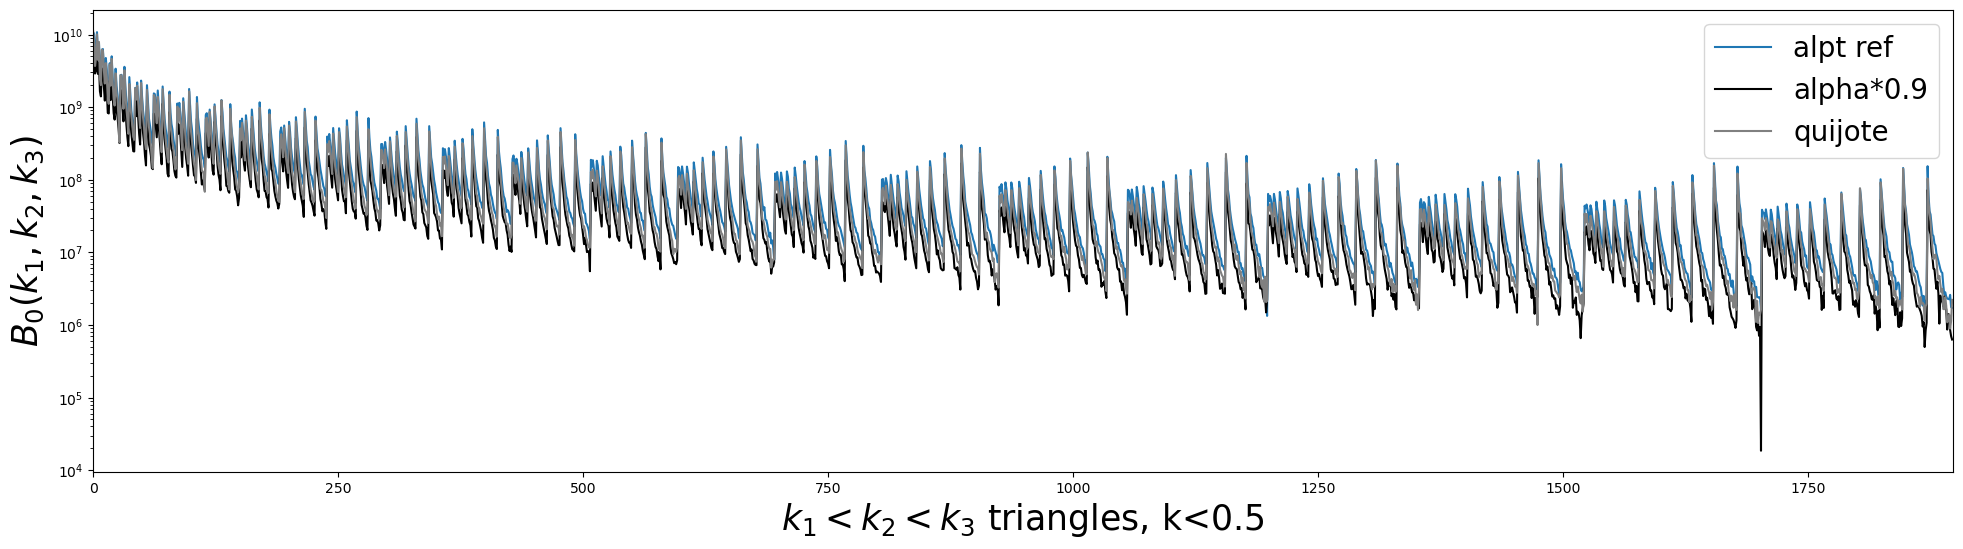

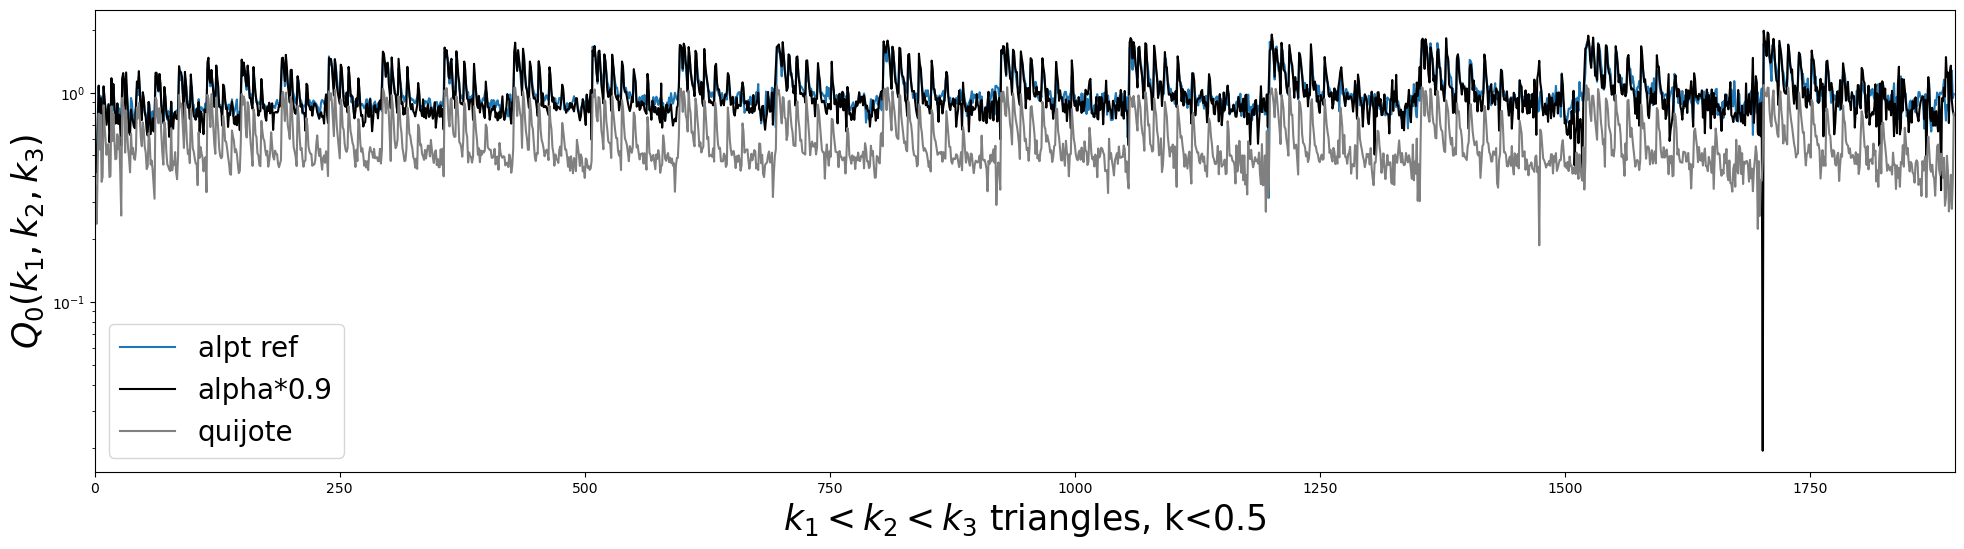

In [27]:
plot_del_Q0B0(b123_alpt, q123_alpt, 'alpha', 0.9, plot_quijote=True)

OM0.313OL0.687G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.313000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 18.0 0.019678354263305664
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...


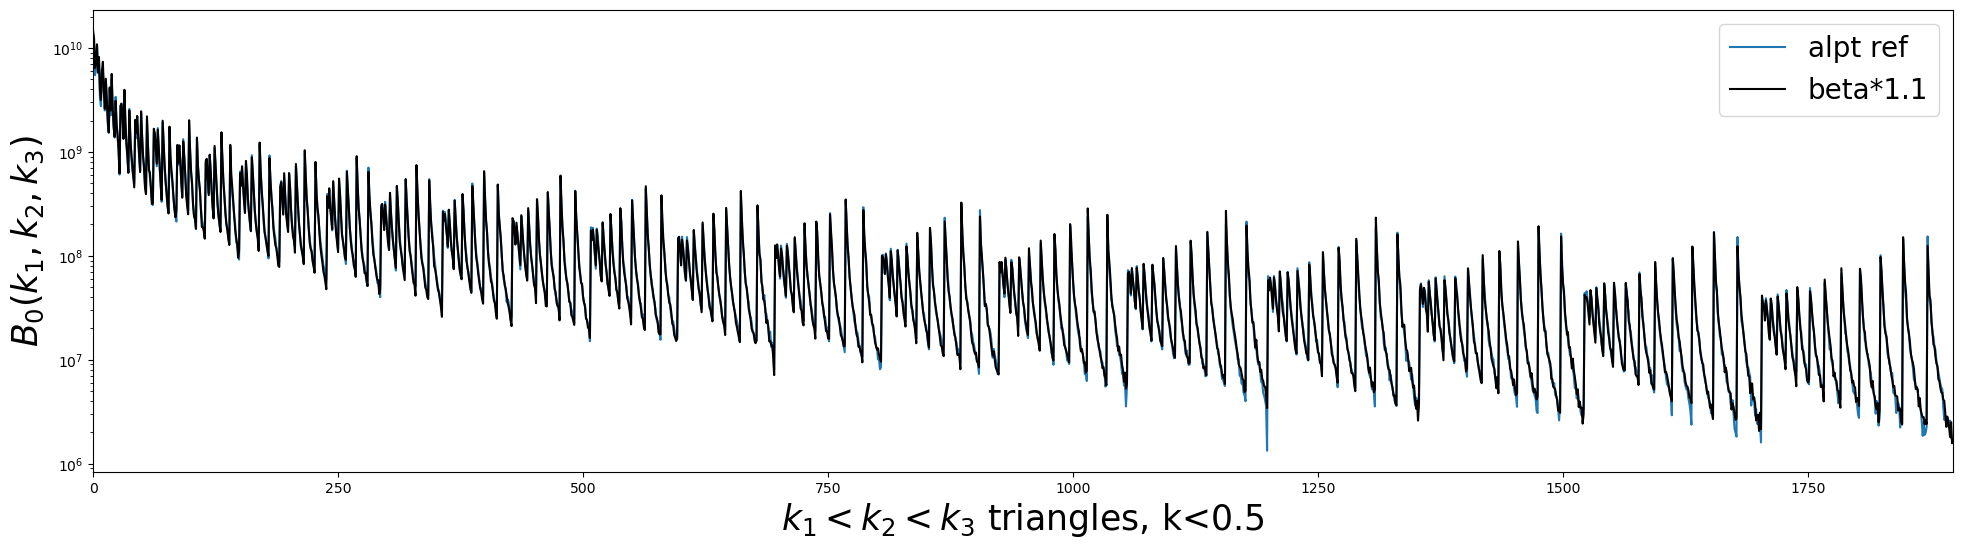

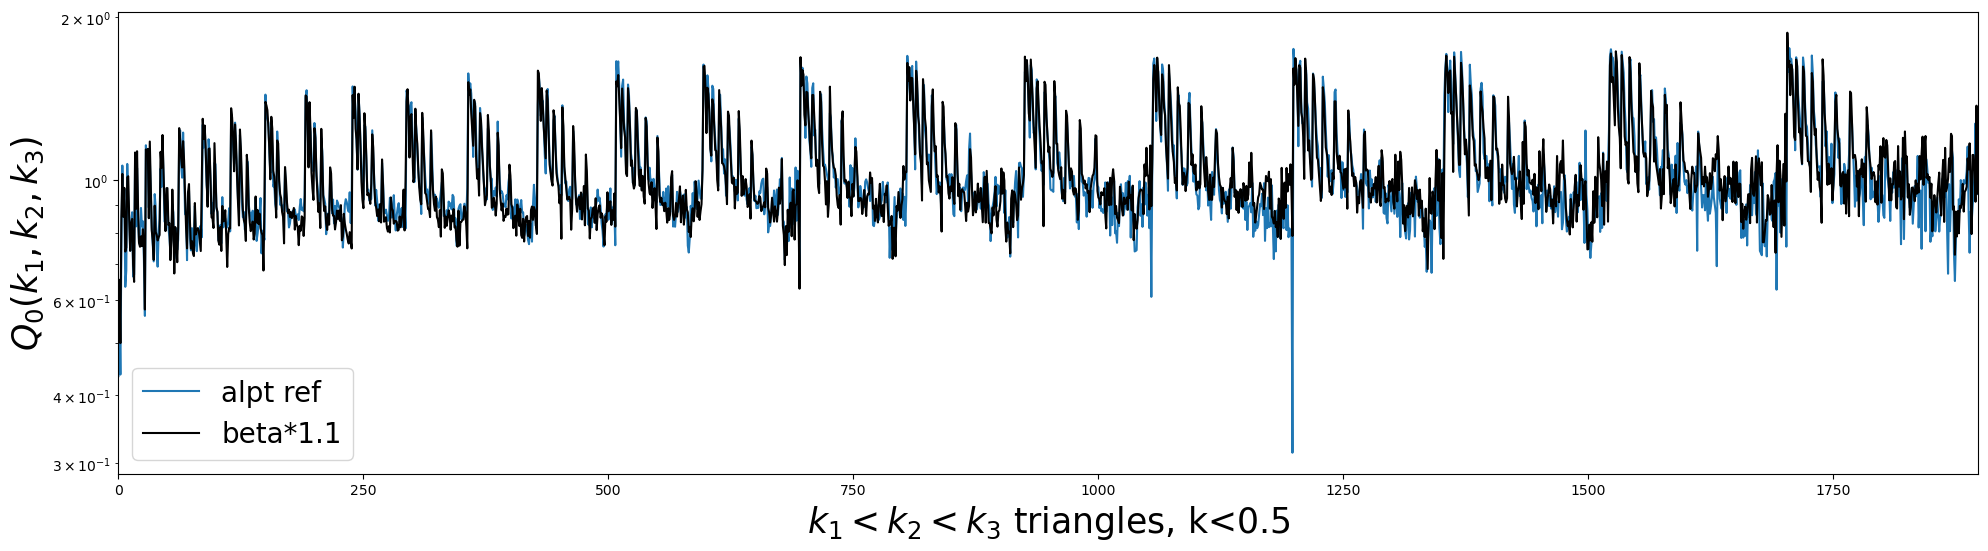

OM0.313OL0.687G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.313000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 18.0 0.019703269004821777
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...


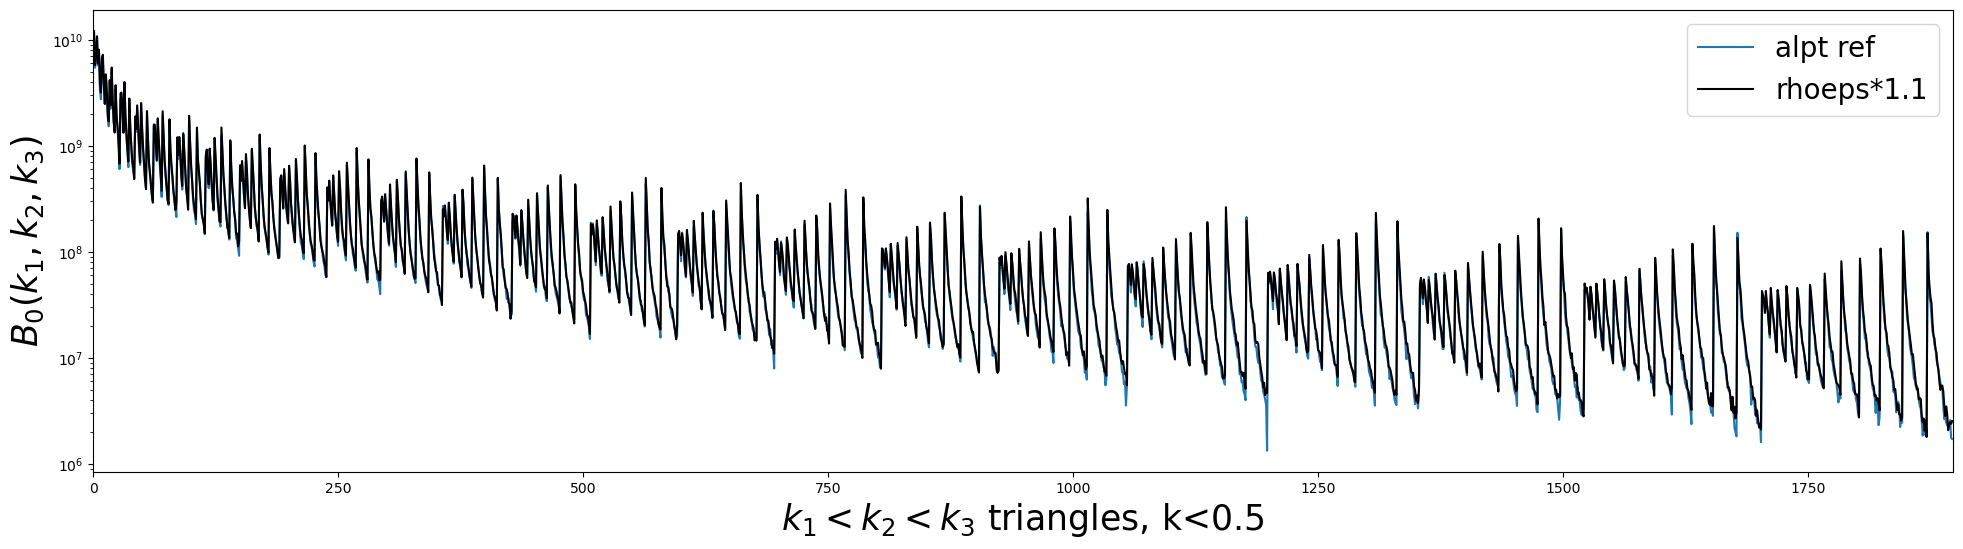

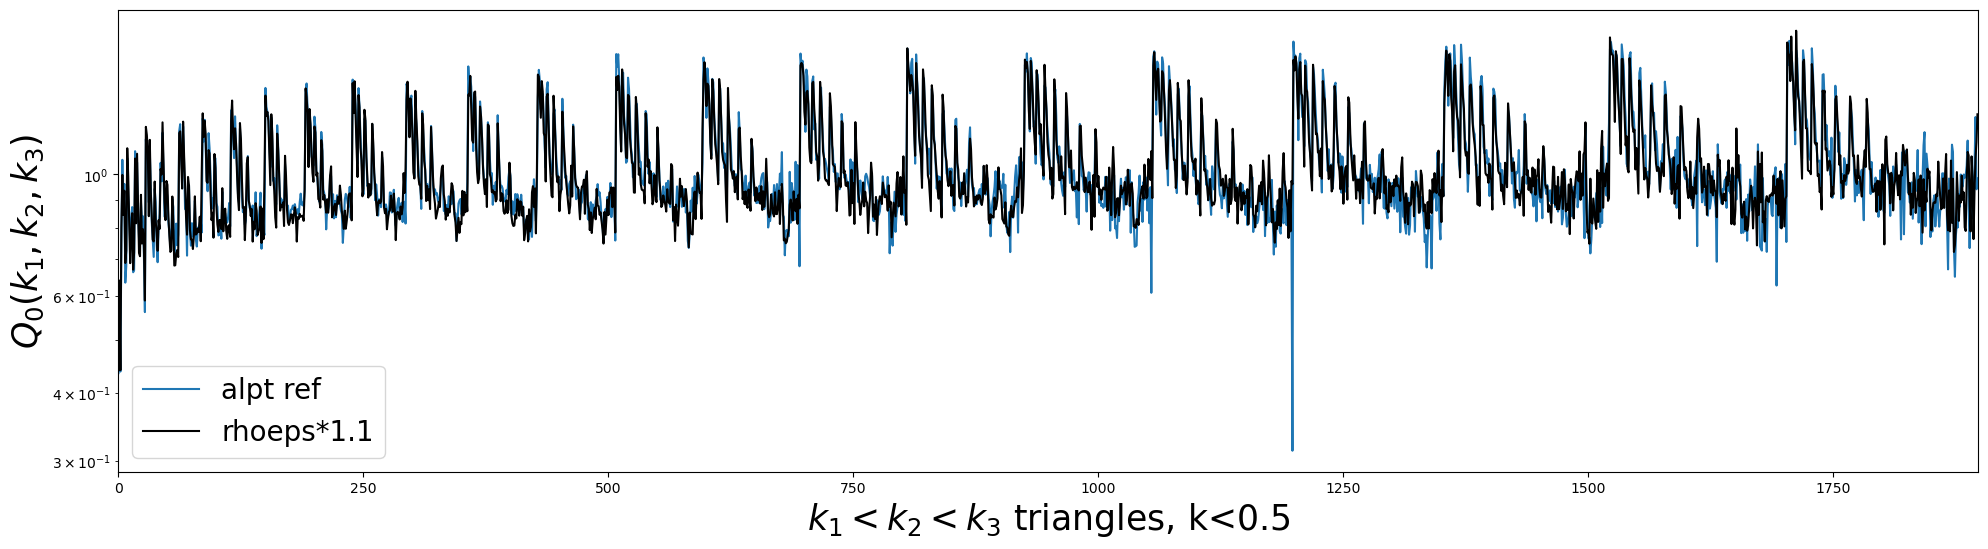

OM0.313OL0.687G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.313000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 14.0 0.01963639259338379
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...


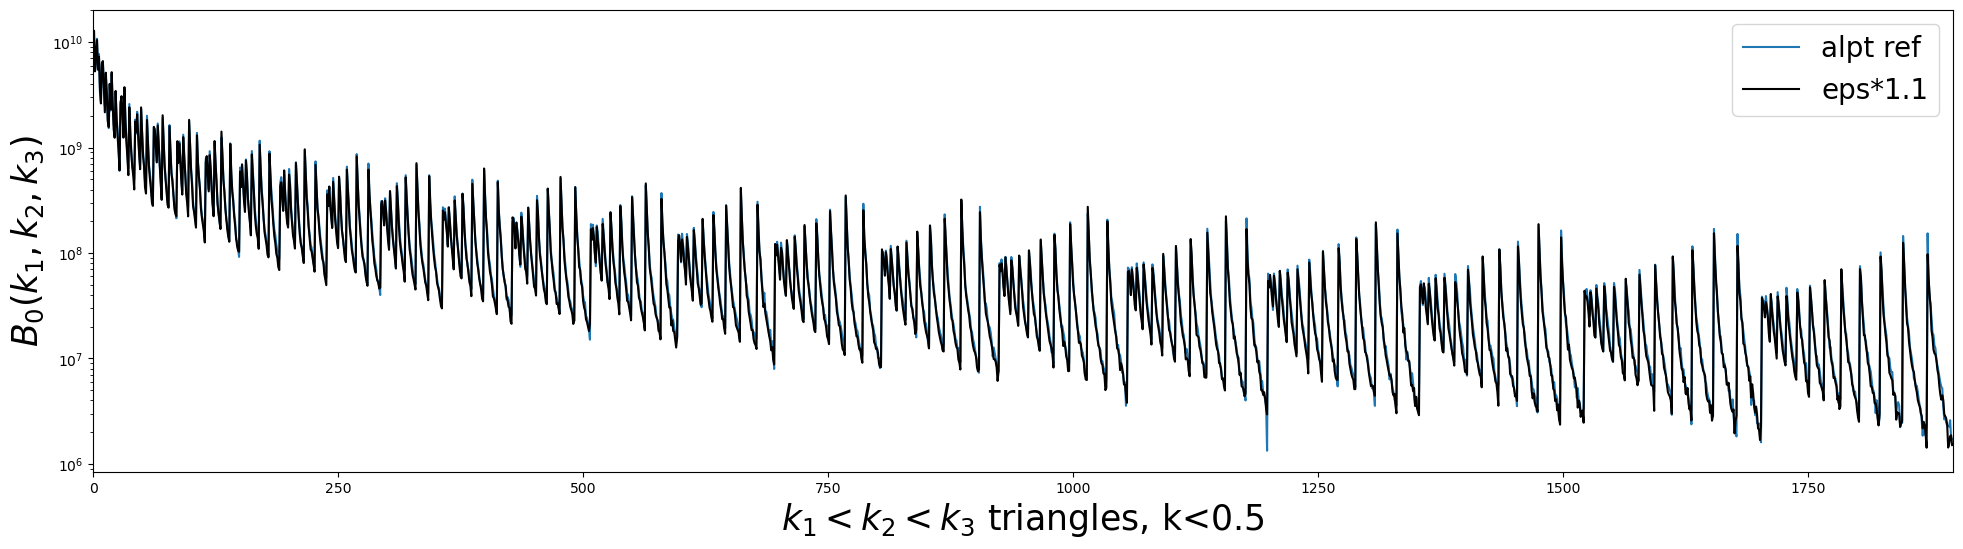

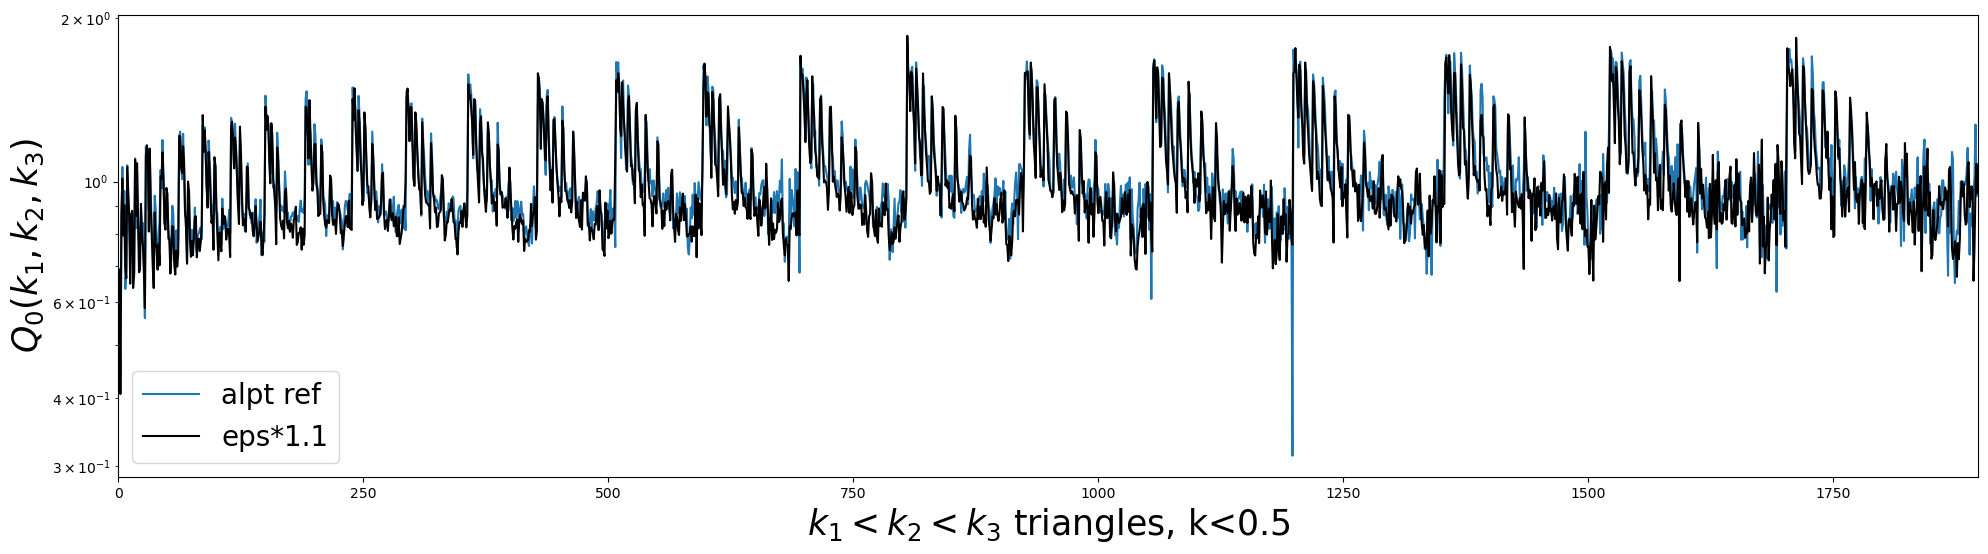

OM0.313OL0.687G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.313000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 22.0 0.02160465717315674
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...


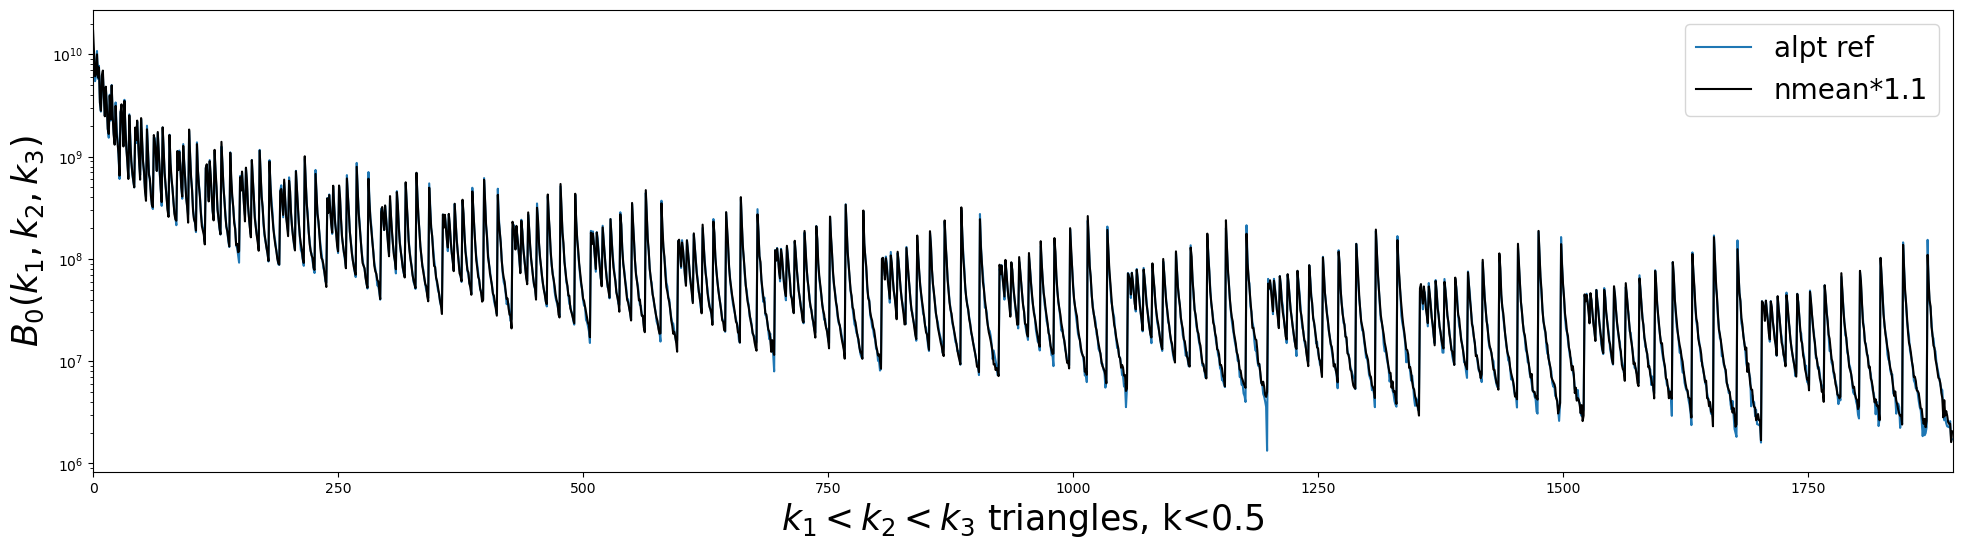

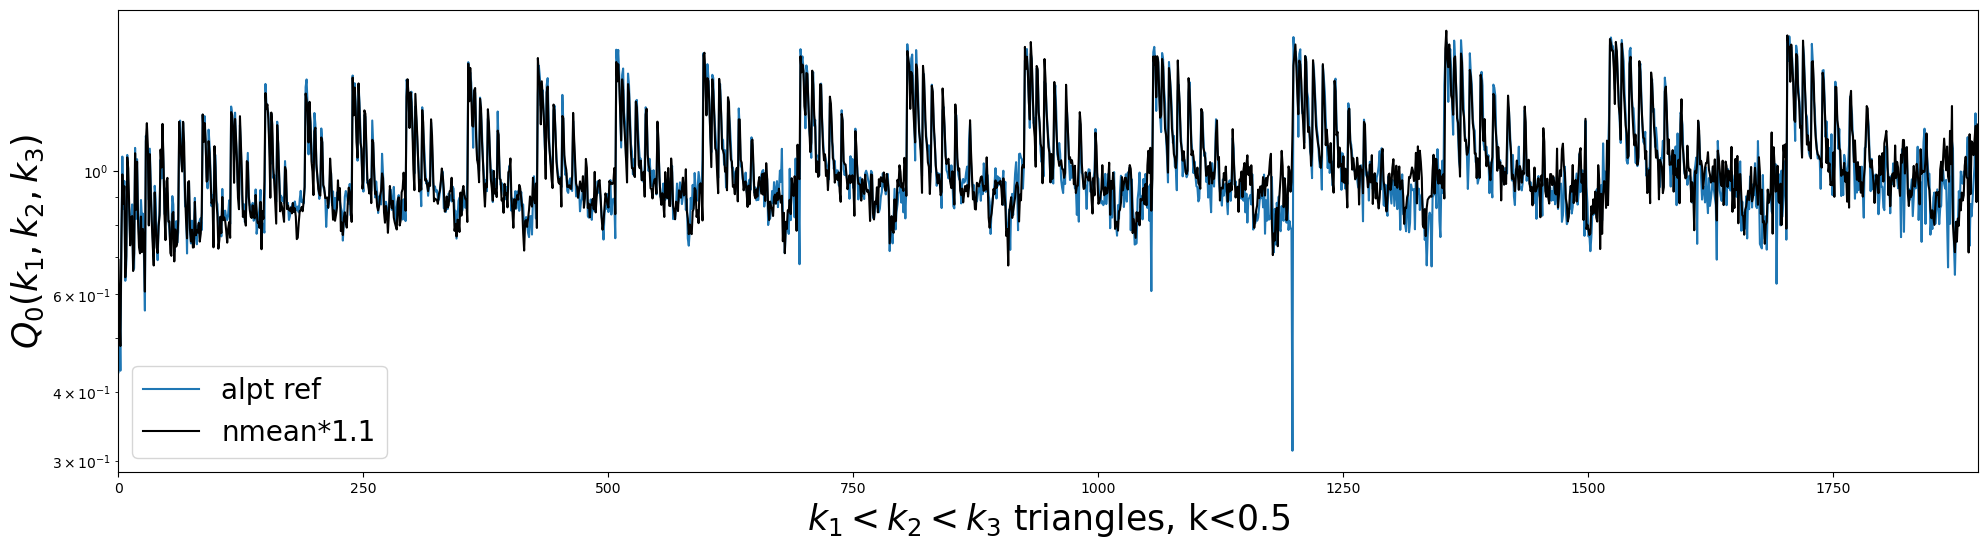

In [ ]:
# test finite diff Gal bias params
plot_del_Q0B0(b123_alpt, q123_alpt, 'beta', 1.5)

plot_del_Q0B0(b123_alpt, q123_alpt, 'rhoeps', 1.5)

plot_del_Q0B0(b123_alpt, q123_alpt, 'eps', 1.5)

plot_del_Q0B0(b123_alpt, q123_alpt, 'nmean', 1.5)

In [ ]:
plot_del_rsd_Q0B0(b123_alpt, q123_alpt, 'bv', 1.1)
plot_del_rsd_Q0B0(b123_alpt, q123_alpt, 'bb', 1.1)
plot_del_rsd_Q0B0(b123_alpt, q123_alpt, 'betarsd', 1.1)
plot_del_rsd_Q0B0(b123_alpt, q123_alpt, 'gamma', 1.1)


In [ ]:
theta_gal_best
theta_rsd = {
    'bv': 0.7289,
    'bb': 1.1652,
    'betarsd': 1.3136,
    'gamma': 0.4944
}

{'alpha': np.float64(1.922999058100232),
 'beta': np.float64(2.0253015048966283),
 'rhoeps': np.float64(14.6873921551893),
 'eps': np.float64(0.5615995289480684),
 'nmean': np.float64(0.00032999996938570635),
 'dth': -0.7889}

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from hodalpt.sims import alpt as CS
from hodalpt.sims import quijote as Q
from hodalpt import stats

In [16]:
theta_gal = {
    'alpha': 1.9230,
    'beta': 2.0253,
    'dth': -0.7889,
    'rhoeps': 14.6874,
    'eps': 0.5616, 
    'nmean': 3.3e-4
}

theta_rsd = {
    'bv': 0.7289,
    'bb': 1.1652,
    'betarsd': 1.3136,
    'gamma': 0.4944
}
outdir = outdir = '/Users/mcc3842/CosmicSim2025/data/quijote/latin_hypercube_HR/100/alpt/'
xyz_g = CS.CSbox_galaxy(theta_gal, theta_rsd, outdir, silent=True)
# spec = stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=True,rsd=2)
bispec = stats.B0_periodic(xyz_g.T, w=None, Lbox=1000., fft='pyfftw', silent=True)

-->Find starting indices ...
-->Start loop over cells of the mesh ...


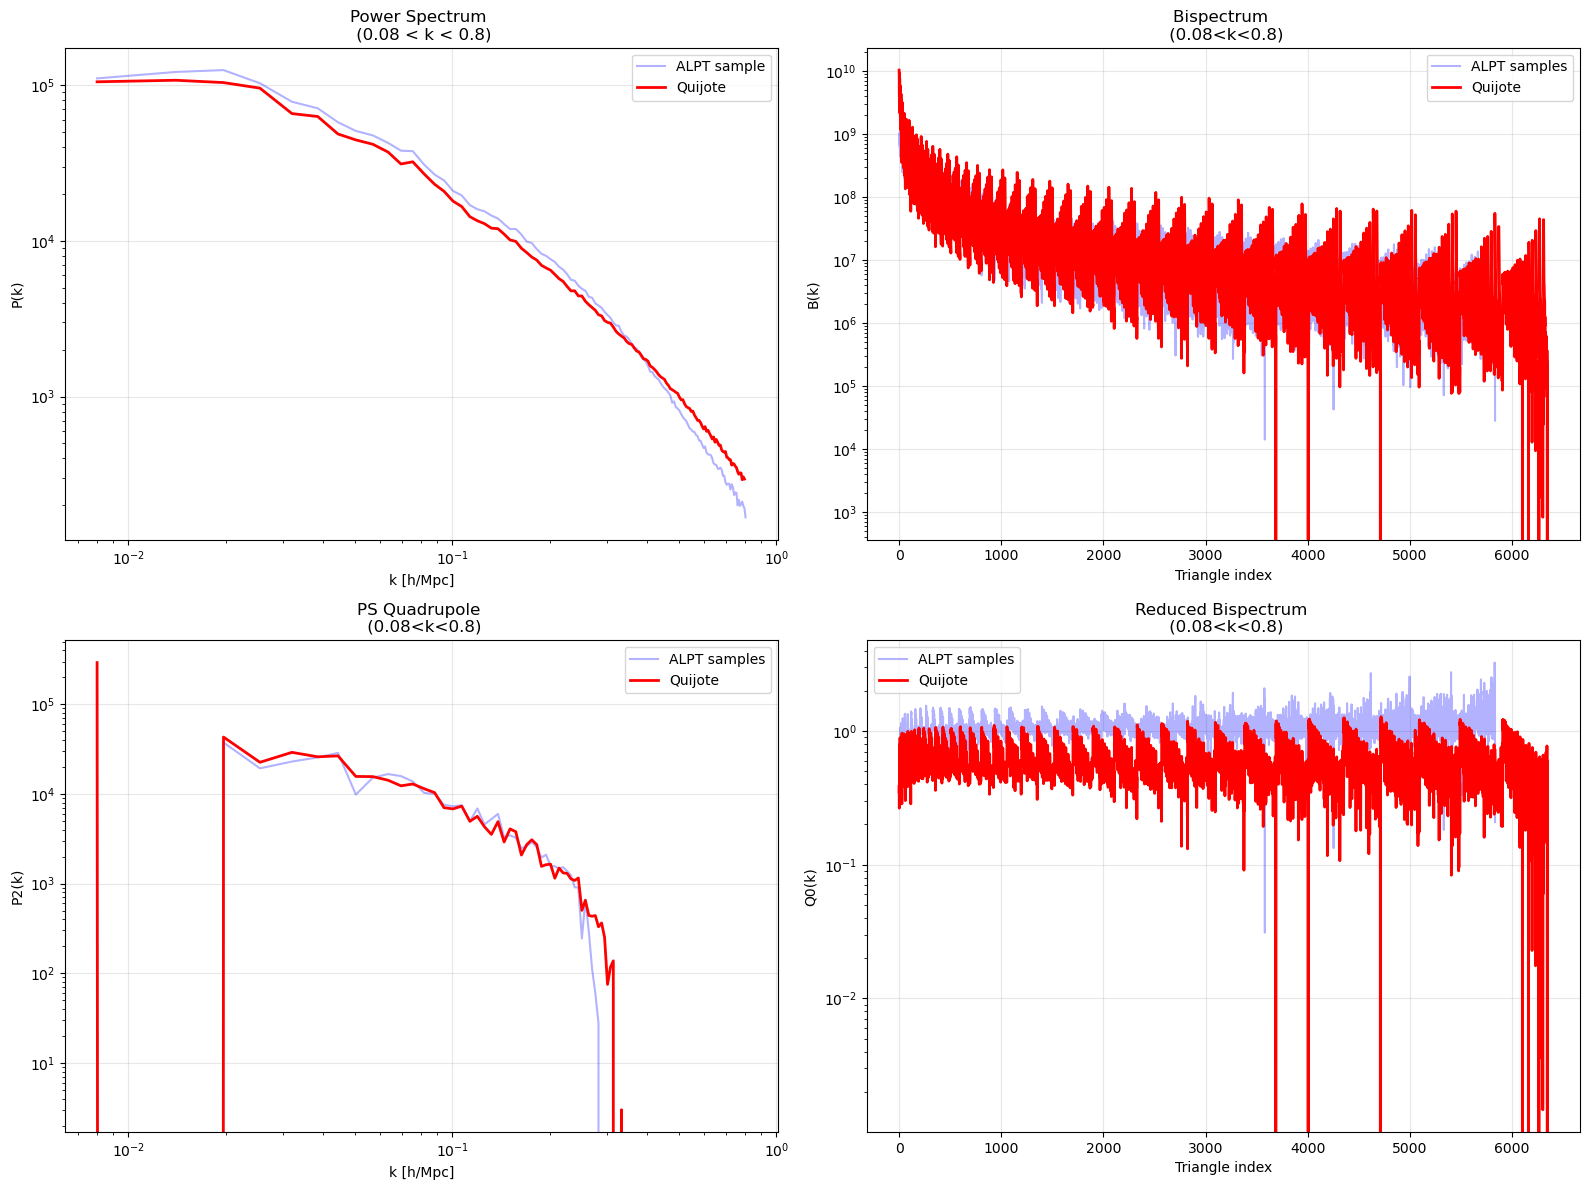

In [18]:
i_k1 = bispec['i_k1']
i_k2 = bispec['i_k2']
i_k3 = bispec['i_k3']

k_fund = 2 * np.pi / 1000.

k1 = i_k1 * k_fund
k2 = i_k2 * k_fund
k3 = i_k3 * k_fund

kmin = 0.08
kmax= 0.8
klim = (k1 > kmin) & (k2 > kmin) & (k3 > kmin) & (k1 < kmax) & (k2 < kmax) & (k3 < kmax)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
# with h5py.File('/Users/mcc3842/CosmicSim2025/alpt_hod_results.h5', 'r') as f:
#     k = f['sample_0/spec/k'][:78]
k = k_bins
# Power spectrum comparison
axes[0].loglog(spec['k'], spec['p0k'], 'b-', alpha=0.3, label='ALPT sample')

for i in range(1):
    axes[0].loglog(k, quijote_pk[i], 'r-', linewidth=2, 
                   label='Quijote' if i == 0 else '')

axes[0].set_xlabel('k [h/Mpc]')
axes[0].set_ylabel('P(k)')
axes[0].set_title(f'Power Spectrum \n ({kmin} < k < {kmax})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# # Bispectrum comparison
axes[1].plot(range(np.sum(klim)), bispec['b123'][klim], 'b-', alpha=0.3, label='ALPT samples')


for i in range(1):
    axes[1].plot(range(quijote_b0.shape[1]), quijote_b0[i], 'r-', linewidth=2,
                 label='Quijote' if i == 0 else '')

axes[1].set_xlabel('Triangle index')
axes[1].set_ylabel('B(k)')
axes[1].set_title(f'Bispectrum \n ({kmin}<k<{kmax})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

# PS Quadrupole comp
axes[2].loglog(spec['k'], spec['p2k'], 'b-', alpha=0.3, label='ALPT samples')


for i in range(1):
    axes[2].loglog(k, quijote_p2k[i], 'r-', linewidth=2,
                 label='Quijote' if i == 0 else '')

axes[2].set_xlabel('k [h/Mpc]')
axes[2].set_ylabel('P2(k)')
axes[2].set_title(f'PS Quadrupole \n ({kmin}<k<{kmax})')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
# axes[1].set_yscale('log')

# # reduced bispectrum
axes[3].plot(range(np.sum(klim)), bispec['q123'][klim], 'b-', alpha=0.3, label='ALPT samples')
# for i in range(1, 200):
#     axes[3].plot(range(alpt_q0.shape[1]), alpt_q0[i], 'b-', alpha=0.3)

for i in range(1):
    axes[3].plot(range(quijote_q0.shape[1]), quijote_q0[i], 'r-', linewidth=2,
                 label='Quijote' if i == 0 else '')

axes[3].set_xlabel('Triangle index')
axes[3].set_ylabel('Q0(k)')
axes[3].set_title(f'Reduced Bispectrum \n ({kmin}<k<{kmax})')
axes[3].legend()
axes[3].grid(True, alpha=0.3)
axes[3].set_yscale('log')

plt.tight_layout()
plt.show()